# Visión por Computador - Práctica 2 - Deep Learning en Computer Vision

#### 12 puntos   |   Fecha de entrega: 15 de Diciembre, 23:59   |   Forma de entrega: a través de la tarea creada en https://pradogrado2425.ugr.es/

### Estudiante: CARMEN AZORÍN MARTÍ



<font color='blue'>El objetivo de esta práctica es aprender a diseñar, implementar, entrenar y utilizar (es decir, aplicar en inferencia) redes neuronales convolucionales en tareas de visión por computador (clasificación y regresión en imágenes) usando fastai (https://docs.fast.ai/).

<font color='blue'>Se proporciona una guía de ayuda (`Assignment_2_HG.ipynb`) para, entre otras cosas, saber cómo:
1. realizar funciones básicas de lectura de datos, entrenamiento y optimización;
2. crear gráficos para la evolución del error de clasificación en
los conjuntos de entrenamiento y validación;
3. y calcular el error de clasificación en el conjunto de prueba.

In [ ]:
# The first thing we should do is to apply hardware acceleration via GPU. So, we have to go to Editar - Configuracion del Cuaderno - Acelerador por Hardware GPU

# Now we SET UP Fastai
!pip install -Uqq fastbook
!pip install nbdev
import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━

In [ ]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()



---



---



---



# <font color='blue'>**Ejercicio 1: BaseNet en CIFAR100 (3 puntos)**

<font color='blue'>**Dataset:**
En este ejercicio, trabajaremos con parte del conjunto de datos CIFAR100 (https://www.cs.toronto.edu/~kriz/cifar.html). Este conjunto de datos consta de $60000$ imágenes en color de $32\times32\times3$ (RGB) que representan 100 clases diferentes ($600$ imágenes por clase). Hay $50000$ imágenes para entrenamiento y $10000$ para test. No obstante, para el desarrollo del ejercicio solo consideraremos $25$ clases (de $100$). Por lo tanto, el conjunto de entrenamiento tendrá $12500$ imágenes y el conjunto de prueba $2500$ imágenes. Los alumnos deben emplear el $10\%$ del conjunto de entrenamiento para  validación.

<font color='blue'>**Modelo BaseNet:**
Comenzamos creando un modelo base llamado *BaseNet* que consta de dos bloques convolucionales (Conv+ReLU) separados por un proceso de *subsampling* (MaxPooling), y una cabeza compuesta por dos capas completamente conectadas (FC) (también llamadas capas densas). La arquitectura precisa se define en la siguiente tabla:

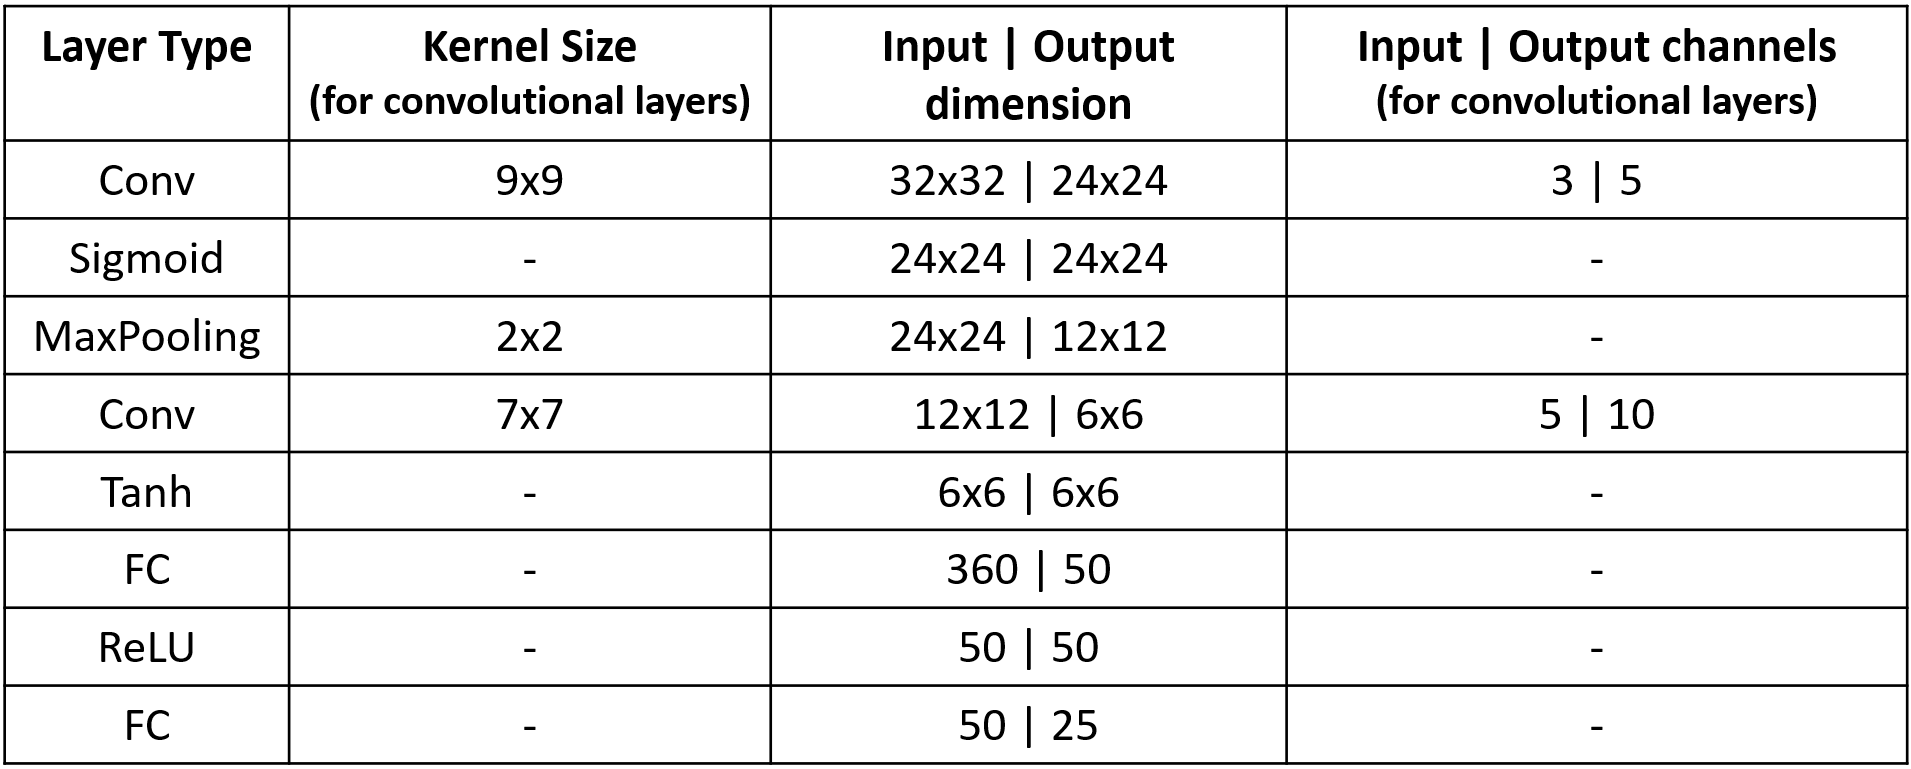

<font color='blue'>Los alumnos deben:
1. Crear el código para el modelo *BaseNet* empleando la librería fastai.
2. Explicar y describir cada una de las capas de la arquitectura *BaseNet*, así como las decisiones de implementación tomadas. Por ejemplo, ¿qué función de pérdida se debería emplear: `CrossEntropyLoss()`, `CrossEntropyLossFlat()` o alguna otra? ¿Se debería incorporar manualmente, en la definición de la red, la función de activación de la capa final (`nn.Softmax()`)? ¿Por qué?
3. Desglosar detalladamente el número de parámetros de esta arquitectura, y cuánto contribuye cada capa a dicho número total. Se debe hacer un `summary()` del modelo para verificar que la arquitectura se ha construido adecuadamente y que el número de parámetros es correcto (es decir, se corresponde con lo esperado).
4. Entrenar el modelo con _Adam_ (incluyendo _early stopping_ con una paciencia de $5$ durante $25$ épocas) y evaluar su rendimiento. En dicha evaluación se debe emplear/mostrar/analizar: la matriz de confusión en entrenamiento, validación y test; la _accuracy_ en entrenamiento, validación y test; y la evolución, por épocas de entrenamiento, tanto de la función de pérdida (en entrenamiento y validación) como de la _accuracy_ (en validación) y el _F1 score (weighted)_ (en validación).



In [ ]:
# We get the CIFAR100 dataset
path = untar_data(URLs.CIFAR_100,force_download=True)

In [ ]:
# The CIFAR_100 dataset, as well as the MNIST dataset, follows a common layout for machine learning datasets:
# separate folders for the training set and the validation set (and/or test set).
# Let's see what's inside both the training and test sets
print(path)
print(path.ls())
print((path/'train').ls())
print((path/'test').ls())
train_classes = (path/'train').ls()
test_classes = (path/'test').ls()
print(len(train_classes))

/root/.fastai/data/cifar100
[Path('/root/.fastai/data/cifar100/train'), Path('/root/.fastai/data/cifar100/test')]
[Path('/root/.fastai/data/cifar100/train/insects'), Path('/root/.fastai/data/cifar100/train/reptiles'), Path('/root/.fastai/data/cifar100/train/people'), Path('/root/.fastai/data/cifar100/train/aquatic_mammals'), Path('/root/.fastai/data/cifar100/train/medium_mammals'), Path('/root/.fastai/data/cifar100/train/large_man-made_outdoor_things'), Path('/root/.fastai/data/cifar100/train/fruit_and_vegetables'), Path('/root/.fastai/data/cifar100/train/food_containers'), Path('/root/.fastai/data/cifar100/train/small_mammals'), Path('/root/.fastai/data/cifar100/train/household_electrical_devices'), Path('/root/.fastai/data/cifar100/train/large_natural_outdoor_scenes'), Path('/root/.fastai/data/cifar100/train/household_furniture'), Path('/root/.fastai/data/cifar100/train/non-insect_invertebrates'), Path('/root/.fastai/data/cifar100/train/fish'), Path('/root/.fastai/data/cifar100/train

Vemos que hay 20 clases, pero eso no debe confundirnos. Eso son solo las 20 superclases en que está subdividido el dataset. Véase https://github.com/fastai/dlcert2/blob/master/docs/datasets.md:
"This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. **The 100 classes in the CIFAR-100 are grouped into 20 superclasses**. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs)."

In [ ]:
# Queremos verificar que dentro de cada una de las 20 superclases hay 5 clases,
# lo que da las 100 clases que hay. También queremos verificar que el número de imágenes
# es correcto
print('Clases dentro de la primera superclase (',train_classes[0],'): ', train_classes[0].ls())
for i in range(20):
  print('Número de clases dentro de superclase ',i,': ', len(train_classes[i].ls()))
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))

Clases dentro de la primera superclase ( /root/.fastai/data/cifar100/train/insects ):  [Path('/root/.fastai/data/cifar100/train/insects/cockroach'), Path('/root/.fastai/data/cifar100/train/insects/beetle'), Path('/root/.fastai/data/cifar100/train/insects/bee'), Path('/root/.fastai/data/cifar100/train/insects/butterfly'), Path('/root/.fastai/data/cifar100/train/insects/caterpillar')]
Número de clases dentro de superclase  0 :  5
Número de clases dentro de superclase  1 :  5
Número de clases dentro de superclase  2 :  5
Número de clases dentro de superclase  3 :  5
Número de clases dentro de superclase  4 :  5
Número de clases dentro de superclase  5 :  5
Número de clases dentro de superclase  6 :  5
Número de clases dentro de superclase  7 :  5
Número de clases dentro de superclase  8 :  5
Número de clases dentro de superclase  9 :  5
Número de clases dentro de superclase  10 :  5
Número de clases dentro de superclase  11 :  5
Número de clases dentro de superclase  12 :  5
Número de cla

Ahora nos quedamos con las primeras 25 clases. Lo que hacemos es eliminar las 75 últimas del dataset.

In [ ]:
#https://stackoverflow.com/questions/185936/how-to-delete-the-contents-of-a-folder
import shutil
number_of_classes_to_keep = 25
number_of_superclasses_to_keep = int(number_of_classes_to_keep/5)
print('SUPERCLASES ELIMINADAS:')
for i in range(number_of_superclasses_to_keep,len(train_classes)):
  print(train_classes[i])
  shutil.rmtree(train_classes[i])
print('SUPERCLASES CONSERVADAS:')
for i in range(number_of_superclasses_to_keep):
  print(train_classes[i])

SUPERCLASES ELIMINADAS:
/root/.fastai/data/cifar100/train/large_man-made_outdoor_things
/root/.fastai/data/cifar100/train/fruit_and_vegetables
/root/.fastai/data/cifar100/train/food_containers
/root/.fastai/data/cifar100/train/small_mammals
/root/.fastai/data/cifar100/train/household_electrical_devices
/root/.fastai/data/cifar100/train/large_natural_outdoor_scenes
/root/.fastai/data/cifar100/train/household_furniture
/root/.fastai/data/cifar100/train/non-insect_invertebrates
/root/.fastai/data/cifar100/train/fish
/root/.fastai/data/cifar100/train/vehicles_2
/root/.fastai/data/cifar100/train/vehicles_1
/root/.fastai/data/cifar100/train/flowers
/root/.fastai/data/cifar100/train/large_carnivores
/root/.fastai/data/cifar100/train/large_omnivores_and_herbivores
/root/.fastai/data/cifar100/train/trees
SUPERCLASES CONSERVADAS:
/root/.fastai/data/cifar100/train/insects
/root/.fastai/data/cifar100/train/reptiles
/root/.fastai/data/cifar100/train/people
/root/.fastai/data/cifar100/train/aquatic_

In [ ]:
# También eliminamos las clases en test
for i in range(number_of_superclasses_to_keep,len(test_classes)):
  print(test_classes[i])
  shutil.rmtree(test_classes[i])

/root/.fastai/data/cifar100/test/large_man-made_outdoor_things
/root/.fastai/data/cifar100/test/fruit_and_vegetables
/root/.fastai/data/cifar100/test/food_containers
/root/.fastai/data/cifar100/test/small_mammals
/root/.fastai/data/cifar100/test/household_electrical_devices
/root/.fastai/data/cifar100/test/large_natural_outdoor_scenes
/root/.fastai/data/cifar100/test/household_furniture
/root/.fastai/data/cifar100/test/non-insect_invertebrates
/root/.fastai/data/cifar100/test/fish
/root/.fastai/data/cifar100/test/vehicles_2
/root/.fastai/data/cifar100/test/vehicles_1
/root/.fastai/data/cifar100/test/flowers
/root/.fastai/data/cifar100/test/large_carnivores
/root/.fastai/data/cifar100/test/large_omnivores_and_herbivores
/root/.fastai/data/cifar100/test/trees


Ahora intentamos verificar si los hemos eliminado realmente.

In [ ]:
print(path)
train_classes = (path/'train').ls()
test_classes = (path/'test').ls()
print(len(train_classes))
print(len(test_classes))

/root/.fastai/data/cifar100
5
5


Y que el número de ejemplos en training y test es el correcto.

In [ ]:
print('Clases dentro de la primera superclase (',train_classes[0],'): ', train_classes[0].ls())
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))

Clases dentro de la primera superclase ( /root/.fastai/data/cifar100/train/insects ):  [Path('/root/.fastai/data/cifar100/train/insects/cockroach'), Path('/root/.fastai/data/cifar100/train/insects/beetle'), Path('/root/.fastai/data/cifar100/train/insects/bee'), Path('/root/.fastai/data/cifar100/train/insects/butterfly'), Path('/root/.fastai/data/cifar100/train/insects/caterpillar')]
Total training images:  12500
Total test images:  2500


Podemos observar que ahora tenemos el dataset tal y como nos interesa, con 12500 imágenes de entrenamiento y 2500 de test.

Ahora vamos a proceder a cargar los datos de entrenamiento. Para ello hacemos uso de DataLoaders y DataBlock.

In [ ]:
# creamos un DataBlock para cargar y preparar los datos
dls = DataBlock(
    # imágenes de entrada y categorías como salida
    blocks=(ImageBlock, CategoryBlock),
    # obtenemos las rutas de las imágenes
    get_items=get_image_files,
    # dividimos dataset en 10% validación y 90% train
    splitter=RandomSplitter(valid_pct=0.1, seed=42),
    # la etiqueta se obtiene del nombre del directorio padre
    get_y=parent_label
).dataloaders(path/'train', bs=32) # creamos dataloader de batch size 32

print('Numero de ejemplos de entrenamiento (una vez descartados los de validacion):', len(dls.train_ds))
print('Numero de ejemplos de validacion:', len(dls.valid_ds))

Numero de ejemplos de entrenamiento (una vez descartados los de validacion): 11250
Numero de ejemplos de validacion: 1250


Example of training data


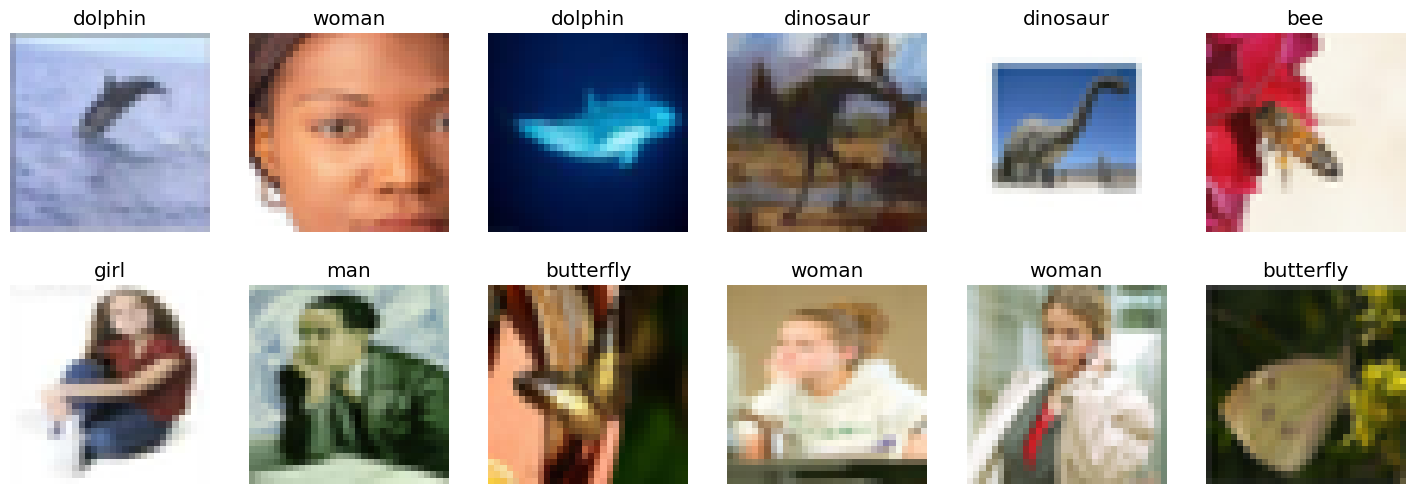

In [ ]:
print('Example of training data')
dls.train.show_batch(max_n=12, nrows=2)

Example of validation data


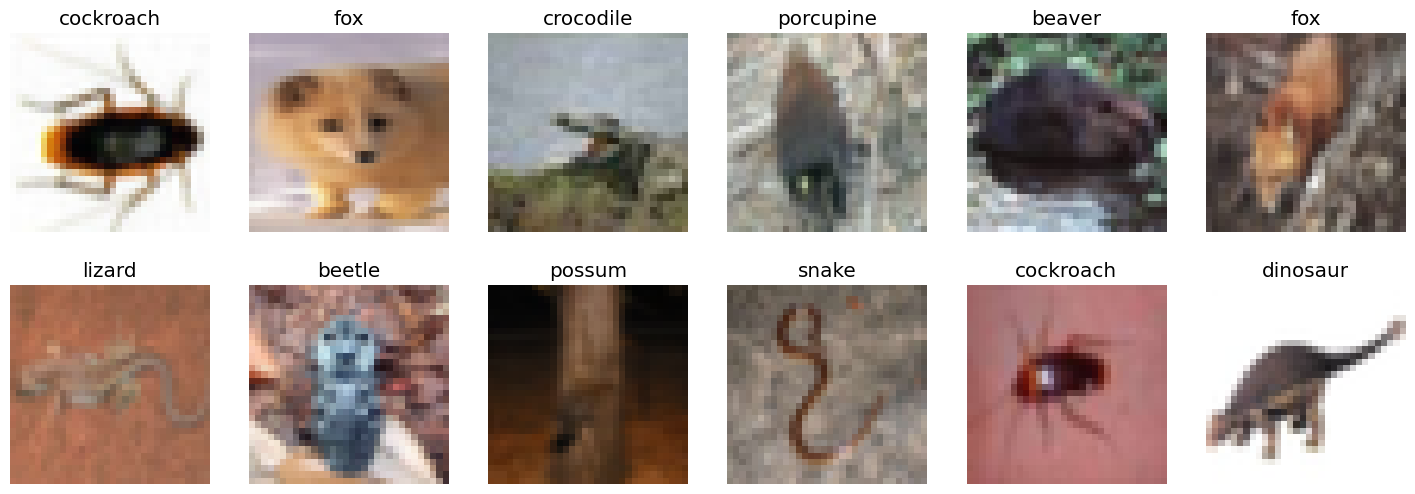

In [ ]:
print('Example of validation data')
dls.valid.show_batch(max_n=12, nrows=2)

Ahora procedemos con la creación y entrenamiento de la red BaseNet.

In [ ]:
from fastai.metrics import F1Score

In [ ]:
# definimos la arquitectura
BaseNet = sequential(
    # capa convolucional con 3 canales de entrada RGB
    nn.Conv2d(in_channels=3,out_channels=5,kernel_size=(9,9)),
    # activación sigmoid
    nn.Sigmoid(),
    # pooling para reducir dimensiones
    nn.MaxPool2d(kernel_size=(2,2)),
    # capa convolcuional con 10 filtros
    nn.Conv2d(in_channels=5,out_channels=10,kernel_size=(7,7)),
    # activación tanh
    nn.Tanh(),
    # aplanamos la salida para usarlas en la capa densa
    nn.Flatten(),
    # capa densa con 360 entradas
    nn.Linear(in_features=360,out_features=50),
    # activación ReLU
    nn.ReLU(),
    # capa final de 25 salidas (número de clases)
    nn.Linear(in_features=50,out_features=25)
  )

BaseNet

Sequential(
  (0): Conv2d(3, 5, kernel_size=(9, 9), stride=(1, 1))
  (1): Sigmoid()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(5, 10, kernel_size=(7, 7), stride=(1, 1))
  (4): Tanh()
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=360, out_features=50, bias=True)
  (7): ReLU()
  (8): Linear(in_features=50, out_features=25, bias=True)
)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,3.021807,2.968041,0.101600,0.059059,00:15
1,2.877866,2.851808,0.149600,0.118834,00:15
2,2.732498,2.725581,0.197600,0.163335,00:13
3,2.556382,2.552431,0.256000,0.237007,00:12
4,2.474235,2.453437,0.281600,0.262707,00:13
5,2.398963,2.417668,0.287200,0.266538,00:14
6,2.335495,2.409543,0.283200,0.271183,00:14
7,2.310665,2.348969,0.305600,0.292999,00:17
8,2.287218,2.306101,0.321600,0.299194,00:14
9,2.194692,2.291020,0.326400,0.309419,00:14


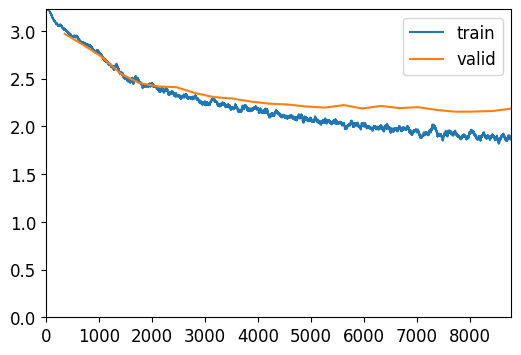

Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 5 x 24 x 24    
Conv2d                                    1220       True      
Sigmoid                                                        
____________________________________________________________________________
                     32 x 5 x 12 x 12    
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 10 x 6 x 6     
Conv2d                                    2460       True      
Tanh                                                           
____________________________________________________________________________
                     32 x 360            
Flatten                                                        
____________________________________________________________________________
                     32 x 50     

In [ ]:
# creamos el  Learner
learn = Learner(dls, BaseNet, loss_func=CrossEntropyLossFlat(), metrics=[accuracy,F1Score(average='weighted')], cbs=[EarlyStoppingCallback(patience=5),ShowGraphCallback()])
# entrenamos el modelo durante 25 épocas
learn.fit(25)
# mostramos el resumen
learn.summary()

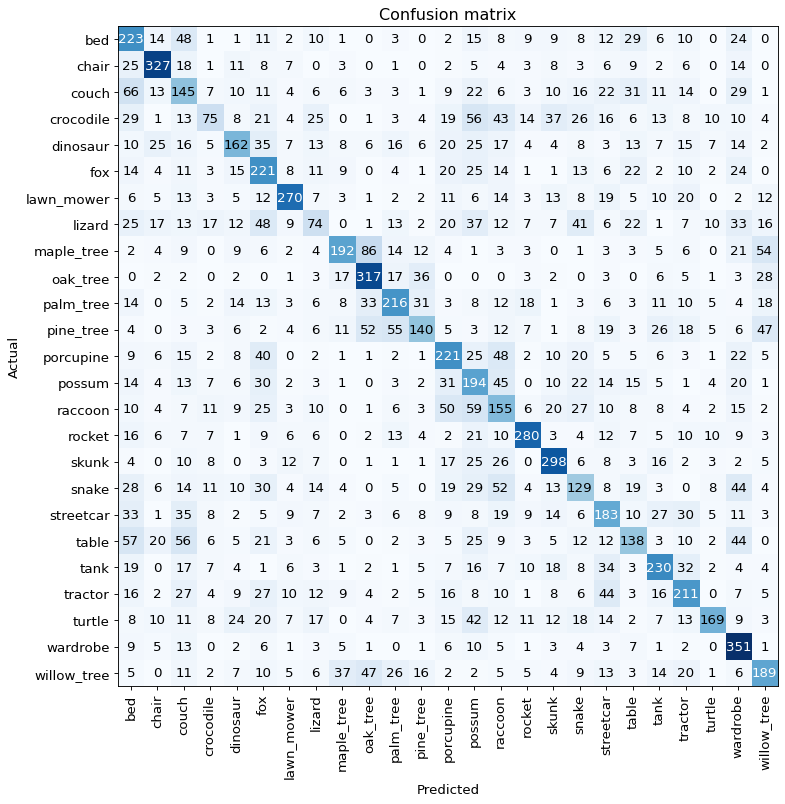

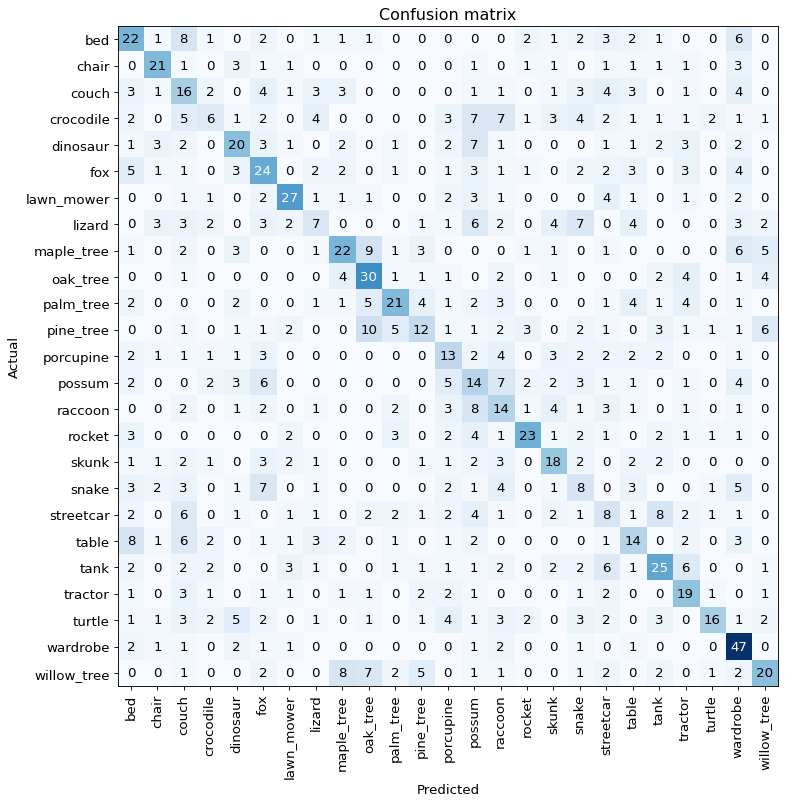

In [ ]:
# evaluamos y mostramos la matriz de confusión para el conjunto de train y validation
splits = ['train','valid']
for split in splits:
  if split == 'train':
    ds = learn.dls.train # dataloader de entrenamiento
  elif split == 'valid':
    ds = learn.dls.valid # dataloader de validación
  else:
    print(f"No se reconoce el conjunto: {split}")
    continue

  # interpretamos los resultados del learner y mostramos la matriz
  interp = ClassificationInterpretation.from_learner(learn, dl=ds)
  interp.plot_confusion_matrix(figsize=(10, 10), dpi=80)

In [ ]:
# calculamos accuracy para entrenamiento
train_preds, train_targets = learn.get_preds(ds_idx=0)
train_acc = accuracy(train_preds, train_targets)
print(f"Train Accuracy: {train_acc.item():.4f}")

# evaluamos las pérdida, accuracy y F1 score en validación
val_loss, val_acc, val_f2 = learn.validate()
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, Validation f2: {val_f2:.4f}")


Train Accuracy: 0.4542


Validation Loss: 2.1853, Validation Accuracy: 0.3736, Validation f2: 0.3697


Test Loss: 2.1476, Test Accuracy: 0.3728, Test f2: 0.3651


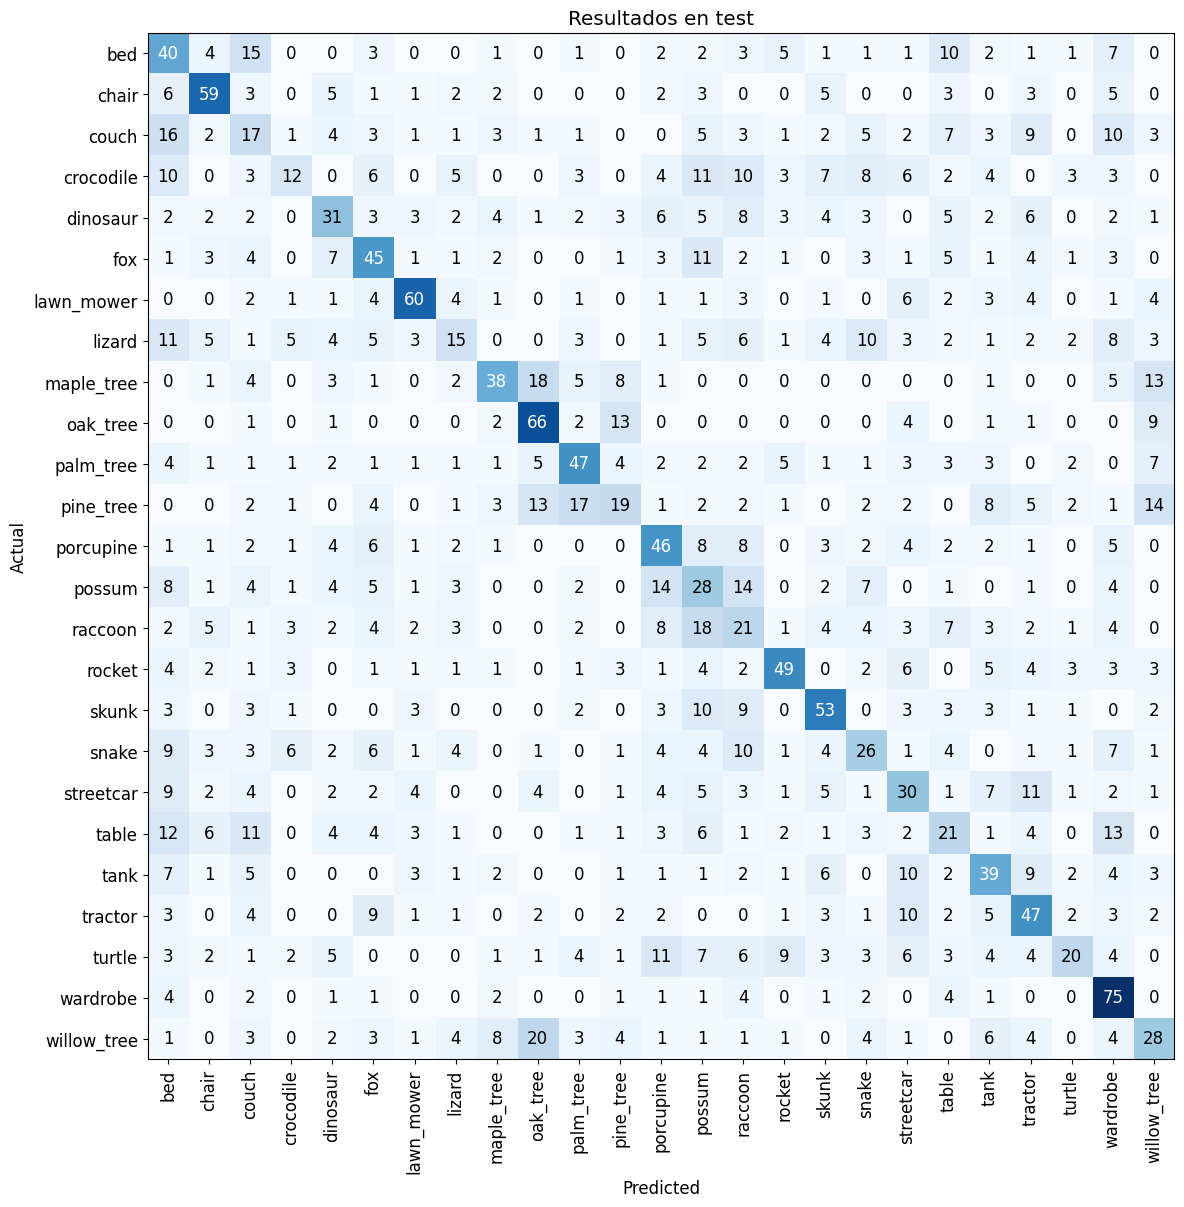

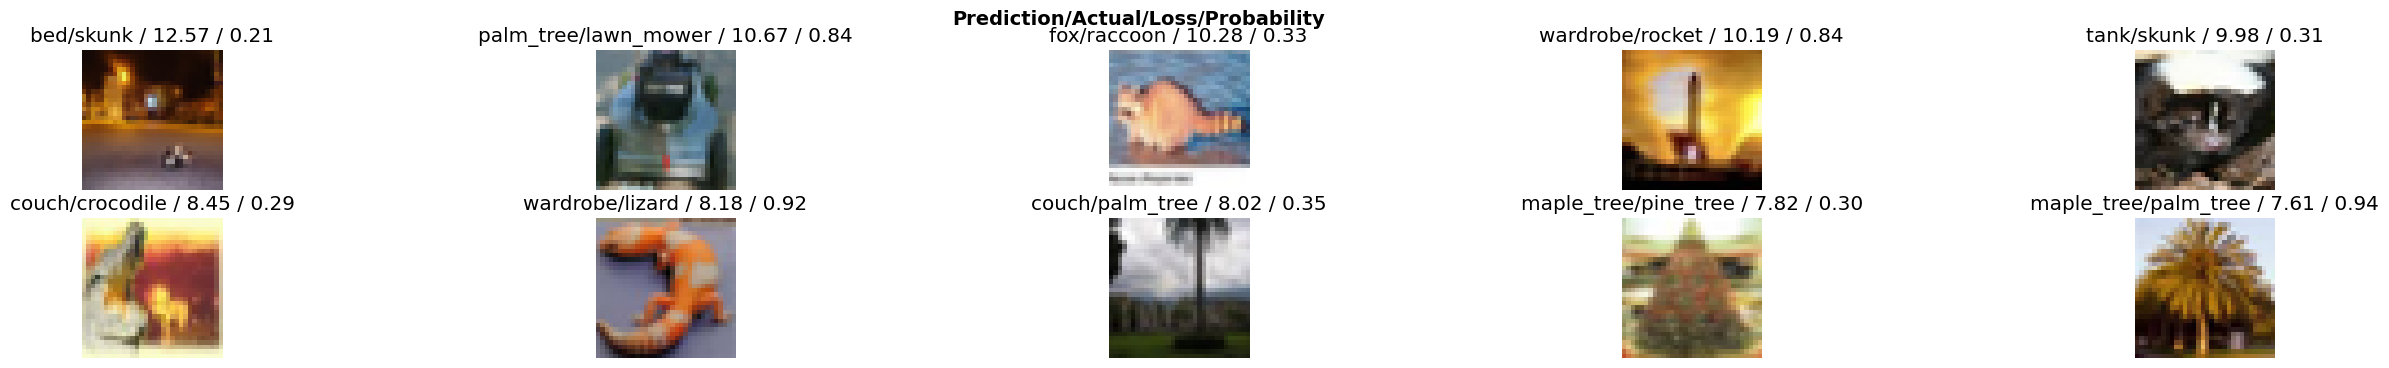

In [ ]:
# creamos dataloader para el conjunto de test
test_dl = learn.dls.test_dl(files_test,with_labels=True)
# evaluamos el rendimiento en test
test_loss, test_acc, test_f2 = learn.validate(dl=test_dl)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Test f2: {test_f2:.4f}")

# interpretamos los resultados en test
test_preds, test_targets = learn.get_preds(dl=test_dl)
interp = ClassificationInterpretation.from_learner(learn, dl=test_dl)
# mostramos la matriz de confusión
interp.plot_confusion_matrix(figsize=(12,12),title='Resultados en test')
# mostramos los casos más confusos
interp.most_confused(min_val=10)
# mostramos las imágenes que el modelo clasificó erróneamente con más confianza
interp.plot_top_losses(10,nrows=2,figsize=(32,4))




---



---



---



# Explicación ejercicio 1

En este ejercicio hemos creado una red con distintas capas. Se empieza con una **red convolucional 2D** que aplica 5 filtros de tamaño 9x9 y sirve para detectar patrones básicos (bordes, colores y texturas). Las imágenes originales están en color (3 canales RGB) y tienen tamaño 32x32 y son las de entrada. Las imágenes de salida de esta capa tendrán tamaño 24x24 con 5 canales, es decir, se eliminan 4 filas o columnas por cada uno de los lados, lo que concuerda con un padding de 0 y un stride de 1. Para calcular el número de parámetros podemos usar la siguiente fórmula:

<center>$(9 \cdot 9 \cdot 3+1) \cdot 5=1220$ parámetros</center>

Son 5 filtros de 9x9 con 3 canales de entrada y 1 parámetro de bias.

La siguiente capa es de activación **Sigmoid**, que sirve para normalizar los valores intermedios entre 0 y 1. No cambia las dimensiones de la imagen y no genera parámetros.

La siguiente capa es **MaxPooling** que reduce la resolución de la imagen a la mitad tomando el valor máximo de cada bloque 2x2. Además el stride es 2, lo que provoca un cambio en la dimensión del output a 12x12. No usa parámetros extra.

La siguiente capa es otra **red convolucional 2D** que aplica 10 filtros de tamaño 7x7 y, al estar en pasos intermedios del modelo, detecta características más complejas. Las imágenes del input son 12x12 con 5 canales y las de salida son 6x6, lo que implica un padding de 0 y un stride de 1. El número de parámetros que usa son:

<center>$(7 \cdot 7 \cdot 5+1) \cdot 10=2460$ parámetros</center>

Son 10 filtros 7x7 con 5 canales de entrada y 1 parámetro de bias.

La siguiente capa es **Tanh** de activación y convierte los valores en el rango (-1,1) y centra los valores en el 0. No cambia las dimensiones de la imagen y no genera parámetros.

La siguiente capa es **Full Connected** que necesita de una capa de **Flatten** que convierta las imágenes a vectores de $6 \cdot 6 \cdot 10 = 360$ elementos. Estos elementos serán el input de la capa densamente conectada y el output serán 50 características globales de las imágenes. No tiene capas intermedias, entonces el número de parámetros entrenados será:

<center>$(360 + 1) \cdot 50 = 18050$ parámetros</center>

La siguiente capa es de activación **ReLU**, que introduce no linealidad reemplazando los valores negativos por 0. No necesita entrenar parámetros.

Finalmente, la última capa también es **Full Connected** que tiene como input un vector de 50 elementos y como output un vector de 25 características, que son las 25 clases en las que pretende clasificar el modelo. El número de parámetros entrenados será:

<center>$(50 + 1) \cdot 25 = 1275$ parámetros</center>

Por tanto, el número de parámetros totales (que son los entrenados) es $1220+2460+18050+1275=23005$, que coincide con el esperado por el summary.

La función de pérdida usada ha sido **CrossEntropyLossFlat**, que es una variante de CrossEntropyLoss para fastai. Esta función combina la capa de Softmax (que asigna las probabilidades de pertenecer a cada clase) y la pérdida de entropía cruzada categórica (indicado en https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). Usamos esta función de pérdida porque estamos en un problema de clasificación multiclase.

Para **evaluar** el rendimiento de nuestro modelo he mostrado la evolución, por épocas de entrenamiento, de las estadísticas y las métricas del learner usando el callback **ShowGraph** (obtenido de https://fastai1.fast.ai/train.html#ShowGraph). Las curvas de entrenamiento muestran que hay aprendizaje, puesto que va decreciendo, pero no demasiado.Además, sabemos que no hay sobreajuste porque las curvas van muy a la par y la accuracy del entrenamiento no es demasiado alta. De hecho, probablemente estemos underfitting y nuetsro modelo requiera mas entrenamiento o mayor capacidad.

**Resultados**

He mostrado la **matriz de confusión** donde cada celda de la matriz representa el número de predicciones realizadas por el modelo en función de las clases verdaderas y las clases predichas. Por tanto, en test vemos que las clases que tienen más prediccion correctas son las de _aquarium_fish_ (30) y _wardrobe_ (40). Mientras que las clases con menos predicciones correctas son _boy_ (5) y _table_ (7).

En train y validation tenemos que las clases con más ejemplos correctamente clasificados son las de _oak_tree_ y _wardrobe_, aunque tienen muchos ejemplos mal clasificados también, es decir, no hay ninguna clase que la prediga siempre bien.

El modelo logra una **accuracy** de 0.4542 en entrenamiento, es un valor relativamente bajo, probablemente debido a que el modelo no es suficientemente potente. Además, la accuracy en validación es 0.3736, indicando que hay underfitting, es decir, el modelo no ha aprendido adecuadamente ni siquiera las características generales del problema. Esto también es reforzado por la accuracy baja de test.

También vemos que el **F2 score** de validación es bajo, lo que confirma que el modelo no distingue bien las clases.




# <font color='blue'> **Ejercicio 2:** **Mejoras sobre el modelo BaseNet (4 puntos)**
<font color='blue'>Ahora el objetivo es crear una versión mejorada del modelo _Base Net_ (implementado en el anterior apartado). Para ello, se puede experimentar con distintas funciones de activación, funciones de pérdida, una mayor o menor profundidad de la red, un mayor o menor número de filtros por bloque convolucional, y/o diferentes técnicas de regularización u optimización, entre otras. De hecho, los alumnos deben sentirse libres para experimentar e incorporar todas las modificaciones que consideren pertinentes, incluyendo elementos no vistos ni en teoría ni en prácticas (por ejemplo, componentes que hayan podido descubrir a través de la revisión de artículos científicos). **Se valorará la originalidad y complejidad de la propuesta realizada.**

<font color='blue'>Es necesario destacar que **es imprescindible justificar de la mejor forma posible las decisiones tomadas** (ya sea mediante evidencia empírica o mediante literatura científica), **así como el rendimiento obtenido** (esto es, intentar explicar qué es lo que hace que mejore tanto el rendimiento). También es importante remarcar que **las mejoras introducidas, dentro de lo posible, deben realizarse de forma incremental**, es decir, no basta con crear directamente (de forma mágica) un único modelo y evaluarlo:  **es necesario justificar y describir qué pasos y resultados intermedios nos han llevado a diseñar ese modelo concreto**. Se debe describir cada una de las mejoras incorporadas, así como analizar los resultados obtenidos (del mismo modo que se hizo en el Ejercicio 1, y empleando los mismos criterios de partida; por ejemplo, usando un $10\%$ de los ejemplos de entrenamiento para validación). También es necesario, al igual que en el Ejercicio 1, desglosar el número de parámetros del modelo final, y se debe hacer un `summary()` del modelo para verificar que la arquitectura se ha construido correctamente y que el número de parámetros se corresponde con lo esperado.  

<font color='blue'>Como referencia para los estudiantes, se espera que la _accuracy_ en validación alcance, como mínimo, el $65\%$.


## Resultado final

Tras experimentar con múltiples modelos y configuraciones, se ha logrado identificar que el modelo de BaseNetMejorada declarado en Prueba 8 proporciona los mejores resultados en este problema de clasificación.

Este modelo es una red convolucional CNN diseñada para capturar características importantes de las imágenes y realizar la clasificación con precisión. La estructura sería la siguiente:

- Capa Convolucional 1 con 32 filtros de tamaño 5x5: reduce la imagen de 32x32 a 28x28. Además, se aplican Batch Normalization, ReLU y Dropout del 20%. Posteriormente, MaxPooling reduce aún más el tamaño de la imagen a 14x14.

- Capa Convolucional 2 con 64 filtros 5x5: reduce la imagen de 14x14 a 10x10. Además, se aplican Batch Normalization, ReLU y Dropout del 20%. Posteriormente, MaxPooling reduce aún más el tamaño de la imagen a 5x5.

- Capa Convolucional 2 con 128 filtros 3x3: reduce la imagen de 5x5 a 3x3. Además, se aplican Batch Normalization, ReLU y Dropout del 20%.

- Capa Densa de 128 neuronas con activación ReLU y otra capa densa con salida 25 neuronas (una por clase).

El diseño del modelo refleja un compromiso entre la profundidad de la red (incluyendo diversas capas convolucionales) y la capacidad de generalización (usando técnicas como Dropout).

El modelo ha sido evaluado en entrenamiento, validación y test y los resultados son los siguientes:
- Train Accuracy: 70.40%
- Validation Accuracy: 62.64% (pérdida: 1.2224)
- Test Accuracy: 61.32% (pérdida: 1.2485)

En cuanto a la matriz de confusión, tenemos clases con buen rendimiento (_wardrobe_ y _shark_) y clases con bajo rendimiento (_bed_ y _rabbit_).

A pesar de las múltiples mejoras intentadas, como ajustar el learning rate, añadir más capas y aplicar otras configuraciones de data augmentation, el modelo no pudo superar el 0.65 de accuracy esperado, quedándose en 0.6264 en validación.



## Entrenamiento
Lo primero que vamos a hacer es aplicarle transformaciones como rotación, zoom y ajustes de iluminación a las imágenes original para generar nuevas. Aplicaremos trasnformaciones como volteos horizontales y pequeños ajustes de iluminación en las imágenes, pero evitamos trasnformaciones demasiado irreales como el volteo vertical.

Esto permitirá al modelo a aprender características más generales y mejorar su capacidad de generalización.

In [ ]:
# creamos DataBlock
dls_aumentada = DataBlock(
    # imágenes como entrada y categorías como salida
    blocks=(ImageBlock, CategoryBlock),
    # obtenemos las imágenes
    get_items=get_image_files,
    # 10% del dataset para validación y 90% para train
    splitter=RandomSplitter(valid_pct=0.1, seed=42),
    # etiqueta extraida del nombre del directorio padre
    get_y=parent_label,
    # aplicamos transformaciones para data augmentation
    batch_tfms=aug_transforms(do_flip=True, # volteo horizontal aleatorio
                              flip_vert=False, # no activamos volteo vertical
                              max_rotate=10, # rotamos imágenes aleatoriamente máx 10 grados
                              max_zoom=1.2, # zoom aleatorio máx 20% mas grande
                              max_lighting=0.2, # brillo y contraste aleatorio
                              max_warp=0.2, # deformaciones pequeñas hasta 20%
                              p_affine=0.75, # probabilidad de aplicar transformaciones de afinidad
                              p_lighting=0.75) # probabilidad de aplicar transformaciones de iluminación
).dataloaders(path/'train', bs=64) # dataloader con batch size de 64

print('Numero de ejemplos de entrenamiento (una vez descartados los de validacion):', len(dls_aumentada.train_ds))
print('Numero de ejemplos de validacion:', len(dls_aumentada.valid_ds))

Numero de ejemplos de entrenamiento (una vez descartados los de validacion): 11250
Numero de ejemplos de validacion: 1250


## Prueba 1

Para mejorar el modelo BaseNet hemos aumentado el número de filtros en las capas convolucionales:
- la primera de 5 a 10 filtros
- la segunda de 16 a 32 filtros

Esto permite capturar más características de la imagen, lo que mejora la capacidad de representación del modelo.

Además, hemos aumentado el número de características en las capas densas: de 360 a 1152, debido a la salida de la capa convolucional. Al mantener más características después de la operación de Flatten, el modelo preservará más información sobre las imágenes.

También hemos añadido Early Stopping con paciencia de 10 épocas en vez de 5, para que el modelo tenga más tiempo para mejorar.

Calculemos el número de parámetros del modelo:

- Primera capa convolucional:
<center>$(3 \cdot 9 \cdot 9)\cdot 16 +16 = 3904$</center>

- Segunda capa convolucional:
<center>$(16 \cdot 7 \cdot 7)\cdot 32 + 32 = 25120$</center>

- Primera capa densa:
<center>$(32 \cdot 6 \cdot 6 )\cdot 50 +50 = 57650$</center>

- Segunda capa densa:
<center>$50 \cdot 25 + 25 = 1275$</center>

Número total de parámetros = 87949.

In [ ]:
BaseNetMejorada = sequential(
    nn.Conv2d(in_channels=3,out_channels=16,kernel_size=(9,9)), #imagenes 32x32 a 24x24
    nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=(2,2)), #imagenes 24x24 a 12x12
    nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(7,7)), #imagenes 12x12 a 6x6
    nn.Tanh(),
    nn.Flatten(),
    nn.Linear(in_features=32*6*6,out_features=50),
    nn.ReLU(),
    nn.Linear(in_features=50,out_features=25)
  )

Para entrenar el modelo vamos a usar el método _fit_one_cycle_ en vez de _fit_ porque implemeta una técnica de optimización más avanzada llamada "One Cycle Policy". Esta técnica se basa en aumentar primero el learning rate durante una parte del ciclo, y luego disminuirla de manera progresiva en la segunda parte. Esto permite que el modelo explore mejor los parámetros en las primeras épocas, ayduando a encontrar una mejor configuración para los pesos. Al final, se reduce el learning rate para que converja mejor.

Además, al reducir el learning rate a medida que entrenamiento avanza, el modelo tiene más probabilidad de generalizar mejor.

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,3.222794,3.216621,0.058400,0.008047,00:19
1,3.161636,3.119829,0.076800,0.039906,00:19
2,3.049983,2.973144,0.121600,0.076138,00:14
3,2.919705,2.823394,0.158400,0.113840,00:14
4,2.726878,2.639814,0.240000,0.215844,00:14
5,2.608912,2.565625,0.238400,0.222719,00:14
6,2.511431,2.486270,0.256800,0.234757,00:15
7,2.441983,2.399780,0.284800,0.279040,00:15
8,2.404983,2.366014,0.315200,0.295558,00:14
9,2.335325,2.326019,0.294400,0.275879,00:14


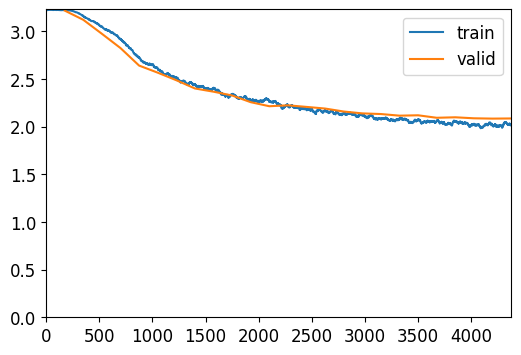

Sequential (Input shape: 64 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 16 x 24 x 24   
Conv2d                                    3904       True      
Sigmoid                                                        
____________________________________________________________________________
                     64 x 16 x 12 x 12   
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 32 x 6 x 6     
Conv2d                                    25120      True      
Tanh                                                           
____________________________________________________________________________
                     64 x 1152           
Flatten                                                        
____________________________________________________________________________
                     64 x 50     

In [ ]:
learn = Learner(dls_aumentada, BaseNetMejorada, loss_func=CrossEntropyLossFlat(), metrics=[accuracy,F1Score(average='weighted')], cbs=[EarlyStoppingCallback(patience=10),ShowGraphCallback()])
learn.fit_one_cycle(25)
learn.summary()

Train Accuracy: 0.4009


Validation Loss: 2.0852, Validation Accuracy: 0.3768


Test Loss: 2.0490, Test Accuracy: 0.3920


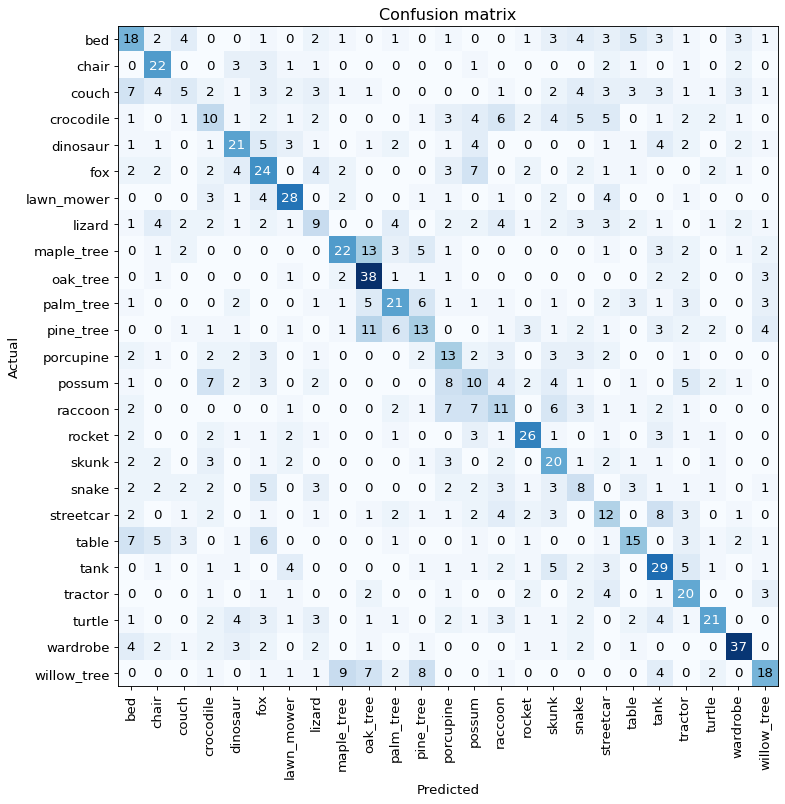

In [ ]:
train_preds, train_targets = learn.get_preds(ds_idx=0)
train_acc = accuracy(train_preds, train_targets)
print(f"Train Accuracy: {train_acc.item():.4f}")

val_loss, val_acc, val_f1 = learn.validate()
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10, 10), dpi=80)

test_dl = learn.dls.test_dl(files_test,with_labels=True)
test_loss, test_acc, test_f1 = learn.validate(dl=test_dl)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Vemos que el accuracy de entrenamiento ha empeorado con respecto a BaseNet, probablemente debido al uso de datos aumentados, que hacen el conjunto de entrenamiento más difícil. Además, tiene una pérdida de validación menor pero un accuracy superior, mostrando que el modelo es capaz de generalizar mejor.

Además, la curva de entrenamiento y validación van muy a la par, ambas decrecen muy lentamente, indicando que el modelo no es lo suficientemente complejo, es decir, hay underfitting. Para solucionarlo, deberíamos aumentar la complejidad del modelo añadiendo más capas o más unidades por capa.

## Prueba 2

Como en el caso anterior teníamos un modelo poco complejo, hemos añadido una capa convolucional y, además, hemos aumentado el número de canales de salida en todas las capas convolucionales.

Por otro lado, hemos puesto los kernels con un tamaño más pequeño 3x3, para que sea capaz dedetectar características más locales en las imágenes.

Ahora tenemos los siguientes parámetros entrenables:
- Primera capa convolucional:
<center>$(3 \cdot 3 \cdot 3 )\cdot 32 +32 = 896$</center>

- Segunda capa convolucional:
<center>$(32 \cdot 3 \cdot 3 )\cdot 64 + 64 = 18496$</center>

- Tercera capa convolucional:
<center>$(64 \cdot 3 \cdot 3 )\cdot 128 +128 = 73856$</center>

- Primera capa densa:
<center>$(128 \cdot 4 \cdot 4 )\cdot 50 +50 = 102450$</center>

- Segunda capa densa:
<center>$50 \cdot 25 + 25 = 1275$</center>

Número total de parámetros = 196973.

In [ ]:
BaseNetMejorada = sequential(
    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=(3,3)), #imagenes 32x32 a 30x30
    nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=(2,2)), #imagenes 30x30 a 15x15
    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3,3)), #imagenes 15x15 a 13x13
    nn.Tanh(),
    nn.MaxPool2d(kernel_size=(2,2)), #imagenes 13x13 a 6x6
    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(3,3)), #imagenes 6x6 a 4x4
    nn.Tanh(),
    nn.Flatten(),
    nn.Linear(in_features=4*4*128,out_features=50),
    nn.ReLU(),
    nn.Linear(in_features=50,out_features=25)
  )

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,3.221687,3.222165,0.041600,0.003323,00:15
1,3.219457,3.218468,0.039200,0.004051,00:15
2,3.026644,2.868058,0.141600,0.098876,00:15
3,2.826256,2.856098,0.144000,0.104417,00:15
4,2.749023,2.679983,0.192800,0.170702,00:14
5,2.707998,2.627235,0.201600,0.179938,00:14
6,2.665650,2.573072,0.224800,0.200654,00:13
7,2.601658,2.514777,0.231200,0.213383,00:17
8,2.578031,2.485154,0.240000,0.224636,00:16
9,2.519252,2.479481,0.246400,0.227523,00:17


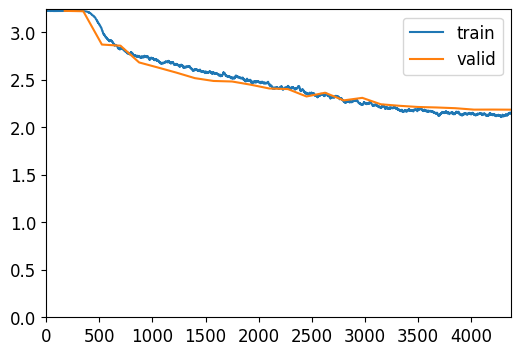

Sequential (Input shape: 64 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 32 x 30 x 30   
Conv2d                                    896        True      
Sigmoid                                                        
____________________________________________________________________________
                     64 x 32 x 15 x 15   
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 64 x 13 x 13   
Conv2d                                    18496      True      
Tanh                                                           
____________________________________________________________________________
                     64 x 64 x 6 x 6     
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 128 x 4

In [ ]:
learn = Learner(dls_aumentada, BaseNetMejorada, loss_func=CrossEntropyLossFlat(), metrics=[accuracy,F1Score(average='weighted')], cbs=[EarlyStoppingCallback(patience=10),ShowGraphCallback()])
learn.fit_one_cycle(25)
learn.summary()

Train Accuracy: 0.3487


Validation Loss: 2.1832, Validation Accuracy: 0.3384


Test Loss: 2.1509, Test Accuracy: 0.3500


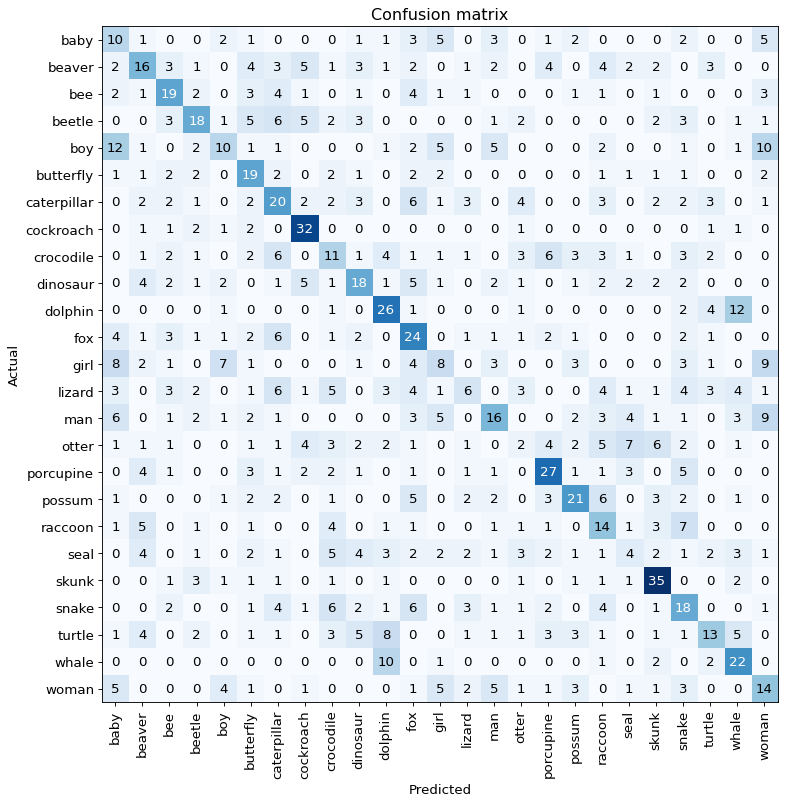

In [ ]:
train_preds, train_targets = learn.get_preds(ds_idx=0)
train_acc = accuracy(train_preds, train_targets)
print(f"Train Accuracy: {train_acc.item():.4f}")

val_loss, val_acc, val_f1 = learn.validate()
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10, 10), dpi=80)

test_dl = learn.dls.test_dl(files_test,with_labels=True)
test_loss, test_acc, test_f1 = learn.validate(dl=test_dl)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Por la curva de entrenamiento vemos que todavía hay mucho underfitting, falta complejidad. además, la accuracy sigue siendo muy baja.

## Prueba 3

Aparte de añadir otra capa convolcuional más con 256 canales de salida, para evitar el problema de desvanecimiento del gradiente (común en funciones de activación como Sigmoid y Tanh), en redes convolucionales usamos ReLU.

Ahora tenemos los siguientes parámetros entrenables:
- Primera capa convolucional:
<center>$(3 \cdot 3 \cdot 3 )\cdot 32 +32 = 896$</center>

- Segunda capa convolucional:
<center>$(32 \cdot 3 \cdot 3 )\cdot 64 + 64 = 18496$</center>

- Tercera capa convolucional:
<center>$(64 \cdot 3 \cdot 3 )\cdot 128 +128 = 73856$</center>

- Cuarta capa convolucional:
<center>$(128 \cdot 3 \cdot 3 )\cdot 256 +256 = 295168$</center>

- Primera capa densa:
<center>$(256 \cdot 2 \cdot 2 )\cdot 50 +50 = 51250$</center>

- Segunda capa densa:
<center>$50 \cdot 25 + 25 = 1275$</center>

Número total de parámetros = 440941.

In [ ]:
BaseNetMejorada = sequential(
    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=(3,3)), #imagenes 32x32 a 30x30
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2)), #imagenes 30x30 a 15x15
    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3,3)), #imagenes 15x15 a 13x13
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2)), #imagenes 13x13 a 6x6
    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(3,3)), #imagenes 6x6 a 4x4
    nn.ReLU(),
    nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(3,3)), #imagenes 4x4 a 2x2
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=2*2*256,out_features=50),
    nn.ReLU(),
    nn.Linear(in_features=50,out_features=25)
  )

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,3.214182,3.194834,0.066400,0.020734,00:18
1,3.042798,2.999340,0.104800,0.048828,00:18
2,2.858273,2.807167,0.160000,0.113090,00:17
3,2.735228,2.653554,0.163200,0.108751,00:18
4,2.673947,2.561678,0.213600,0.161990,00:17
5,2.571736,2.487533,0.236800,0.190049,00:15
6,2.481894,2.347769,0.282400,0.252378,00:17
7,2.385357,2.322757,0.275200,0.236572,00:17
8,2.316651,2.248187,0.295200,0.273836,00:15
9,2.272219,2.196606,0.316800,0.285333,00:15


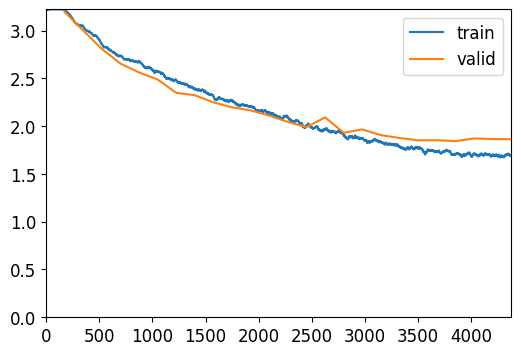

Sequential (Input shape: 64 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 32 x 30 x 30   
Conv2d                                    896        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 15 x 15   
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 64 x 13 x 13   
Conv2d                                    18496      True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 6 x 6     
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 128 x 4

In [ ]:
learn = Learner(dls_aumentada, BaseNetMejorada, loss_func=CrossEntropyLossFlat(), metrics=[accuracy,F1Score(average='weighted')], cbs=[EarlyStoppingCallback(patience=10),ShowGraphCallback()])
learn.fit_one_cycle(25)
learn.summary()

Train Accuracy: 0.4732


Validation Loss: 1.8629, Validation Accuracy: 0.4376


Test Loss: 1.8817, Test Accuracy: 0.4344


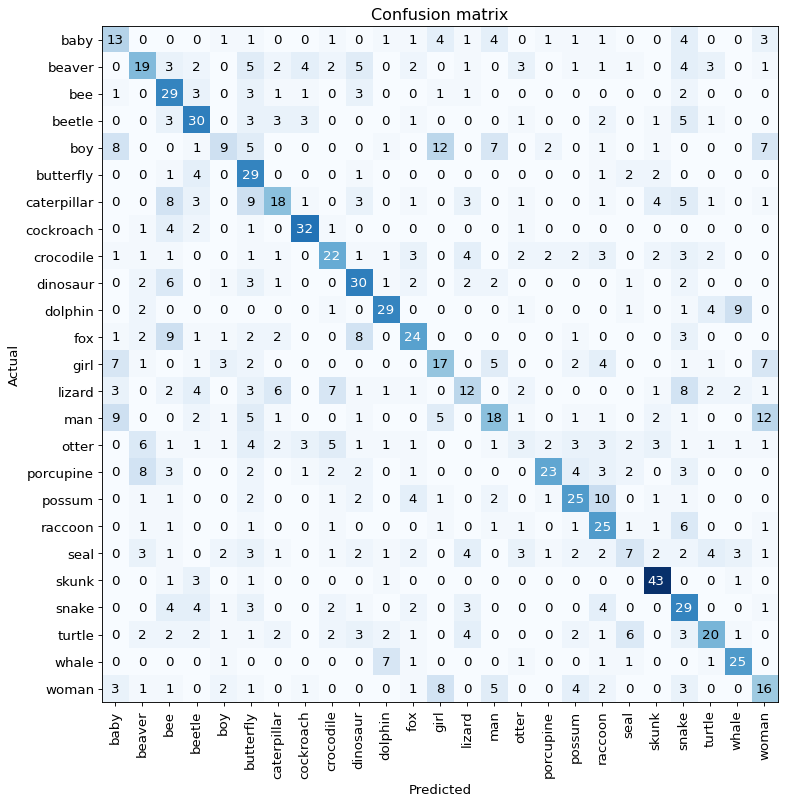

In [ ]:
train_preds, train_targets = learn.get_preds(ds_idx=0)
train_acc = accuracy(train_preds, train_targets)
print(f"Train Accuracy: {train_acc.item():.4f}")

val_loss, val_acc, val_f1 = learn.validate()
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10, 10), dpi=80)

test_dl = learn.dls.test_dl(files_test,with_labels=True)
test_loss, test_acc, test_f1 = learn.validate(dl=test_dl)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Vemos que la mejora del modelo ha sido muy grande, hemos pasado a tener un accuracy mucho más elevado que antes. Además, ahora vemos que las curvas de entrenamiento decrecen más rápidamente y, además, empiezan a separarse. Parece que la curva de entrenamiento empieza a bajar más rápido de que la de validación. Esto indica que empieza a haber un poco de overfitting, probablemente debido al aumento del número de capas convolucionales.

## Prueba 4

Para prevenir el overfitting vamos a agregar capas de Dropout, para evitar que el modelo dependa demsiado de unas pocas neuronas.

Además, para acelerar el entrenamiento, también vamos a añadir Batch Normalization. BN normaliza las activaciones de cada capa para que tengan media 0 y varianza 1 en cda mini.batch, así evitamos que las activaciones sean demasiado grandes o pequeñas, estabilizando el entrenamiento. también puede servir como regularizador al introducir variablidad en las activaciones de cada mini-batch.

Dropout no incluye parámetros, pero las capas de Batch Normalization incluyen 2 parámetros por canal, es decir:

- Primera capa BN:
<center>$2 \cdot 32 = 64$</center>

- Segunda capa BN:
<center>$2 \cdot 64 = 128$</center>

- Tercera capa BN:
<center>$2 \cdot 128 = 256$</center>

- Primera capa BN:
<center>$2 \cdot 256 = 512$</center>

Número de paráemtros añadidos: 960

Número de parámetros totales: 441901

In [ ]:
BaseNetMejorada = sequential(
    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=(3,3)), #imagenes 32x32 a 30x30
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.MaxPool2d(kernel_size=(2,2)), #imagenes 30x30 a 15x15
    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3,3)), #imagenes 15x15 a 13x13
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.MaxPool2d(kernel_size=(2,2)), #imagenes 13x13 a 6x6
    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(3,3)), #imagenes 6x6 a 4x4
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(3,3)), #imagenes 4x4 a 2x2
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=2*2*256,out_features=50),
    nn.ReLU(),
    nn.Linear(in_features=50,out_features=25)
  )

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,3.010308,2.962056,0.170400,0.125146,00:16
1,2.641236,2.537625,0.260000,0.239299,00:23
2,2.384915,2.345644,0.275200,0.261010,00:17
3,2.262388,2.481121,0.284800,0.253244,00:16
4,2.163704,2.322790,0.308000,0.278728,00:19
5,2.085737,2.175230,0.328000,0.313074,00:19
6,2.018026,2.250542,0.328800,0.309620,00:16
7,1.914811,2.210090,0.336800,0.320769,00:16
8,1.871199,2.072206,0.370400,0.356015,00:17
9,1.798247,2.310231,0.324000,0.305193,00:18


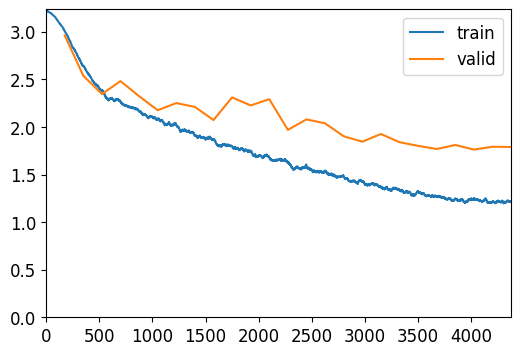

Sequential (Input shape: 64 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 32 x 30 x 30   
Conv2d                                    896        True      
BatchNorm2d                               64         True      
ReLU                                                           
Dropout                                                        
____________________________________________________________________________
                     64 x 32 x 15 x 15   
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 64 x 13 x 13   
Conv2d                                    18496      True      
BatchNorm2d                               128        True      
ReLU                                                           
Dropout                                                        
_____________________________________

In [ ]:
learn = Learner(dls_aumentada, BaseNetMejorada, loss_func=CrossEntropyLossFlat(), metrics=[accuracy,F1Score(average='weighted')], cbs=[EarlyStoppingCallback(patience=10),ShowGraphCallback()])
learn.fit_one_cycle(25)
learn.summary()

Train Accuracy: 0.5305


Validation Loss: 1.7891, Validation Accuracy: 0.4704


Test Loss: 1.8216, Test Accuracy: 0.4656


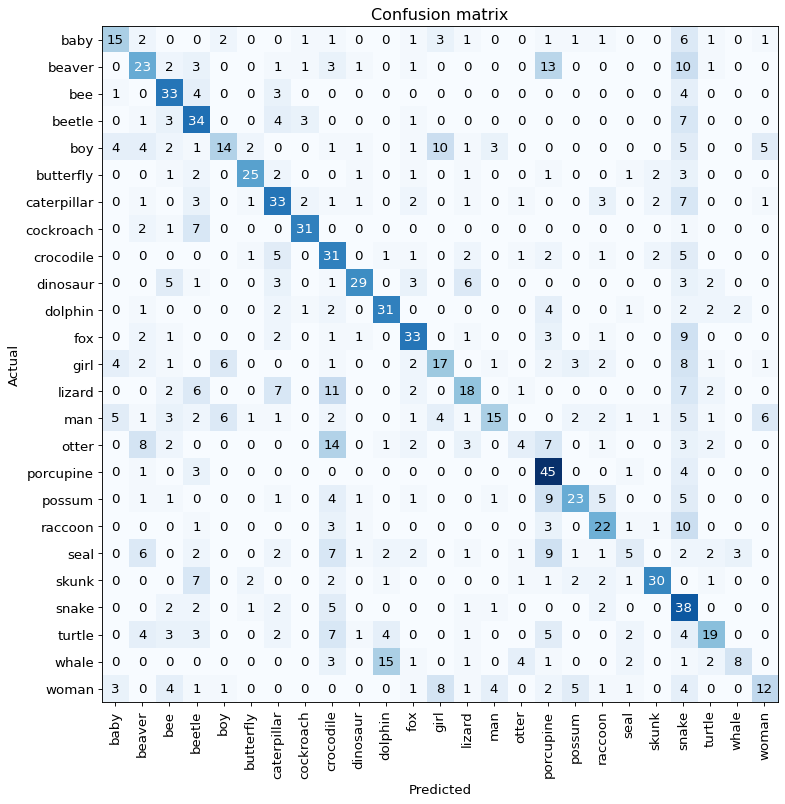

In [ ]:
train_preds, train_targets = learn.get_preds(ds_idx=0)
train_acc = accuracy(train_preds, train_targets)
print(f"Train Accuracy: {train_acc.item():.4f}")

val_loss, val_acc, val_f1 = learn.validate()
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10, 10), dpi=80)

test_dl = learn.dls.test_dl(files_test,with_labels=True)
test_loss, test_acc, test_f1 = learn.validate(dl=test_dl)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Vemos que los resultados han vuelto a mejorar con respecto al caso anterior. La curva de entrenamiento baja mucho más rápido que antes gracias al Batch Normalization y las métricas de rendimiento son mejores.

Sin embargo, las curvas de validación y entrenamiento cada vez se separan más.

## Prueba 5

Para reducir el overfitting vamos a aumentar la probabilidad de que las neuronas sean desactivadas de 20% a 50%, esto permitirá generalizar el modelo.

El número de parámetros sigue mantenieéndose constante.

In [ ]:
BaseNetMejorada = sequential(
    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=(3,3)), #imagenes 32x32 a 30x30
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.MaxPool2d(kernel_size=(2,2)), #imagenes 30x30 a 15x15
    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3,3)), #imagenes 15x15 a 13x13
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.MaxPool2d(kernel_size=(2,2)), #imagenes 13x13 a 6x6
    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(3,3)), #imagenes 6x6 a 4x4
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(3,3)), #imagenes 4x4 a 2x2
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Flatten(),
    nn.Linear(in_features=2*2*256,out_features=50),
    nn.ReLU(),
    nn.Linear(in_features=50,out_features=25)
  )

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,3.196678,3.196362,0.080800,0.052095,00:20
1,2.919540,3.114833,0.072800,0.029612,00:19
2,2.651049,3.097884,0.081600,0.040914,00:20
3,2.530904,3.213676,0.094400,0.051201,00:19
4,2.441468,3.332039,0.092800,0.064550,00:17
5,2.344604,3.499541,0.100000,0.052997,00:15
6,2.307025,3.214756,0.125600,0.081889,00:15
7,2.236473,3.649859,0.077600,0.059412,00:17
8,2.194899,3.510470,0.128000,0.072243,00:19
9,2.126975,3.379781,0.141600,0.110420,00:22


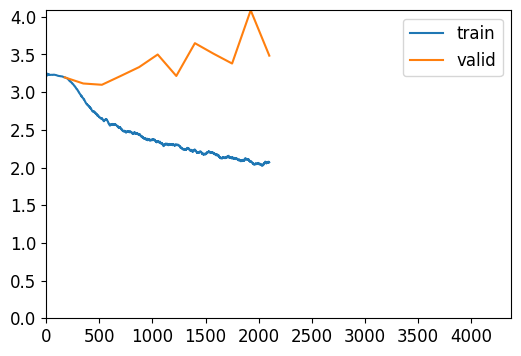

No improvement since epoch 2: early stopping


Sequential (Input shape: 64 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 32 x 30 x 30   
Conv2d                                    896        True      
BatchNorm2d                               64         True      
ReLU                                                           
Dropout                                                        
____________________________________________________________________________
                     64 x 32 x 15 x 15   
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 64 x 13 x 13   
Conv2d                                    18496      True      
BatchNorm2d                               128        True      
ReLU                                                           
Dropout                                                        
_____________________________________

In [ ]:
learn = Learner(dls_aumentada, BaseNetMejorada, loss_func=CrossEntropyLossFlat(), metrics=[accuracy,F1Score(average='weighted')], cbs=[EarlyStoppingCallback(patience=10),ShowGraphCallback()])
learn.fit_one_cycle(25)
learn.summary()

Train Accuracy: 0.1049


Validation Loss: 3.2218, Validation Accuracy: 0.1408


Test Loss: 3.3567, Test Accuracy: 0.1256


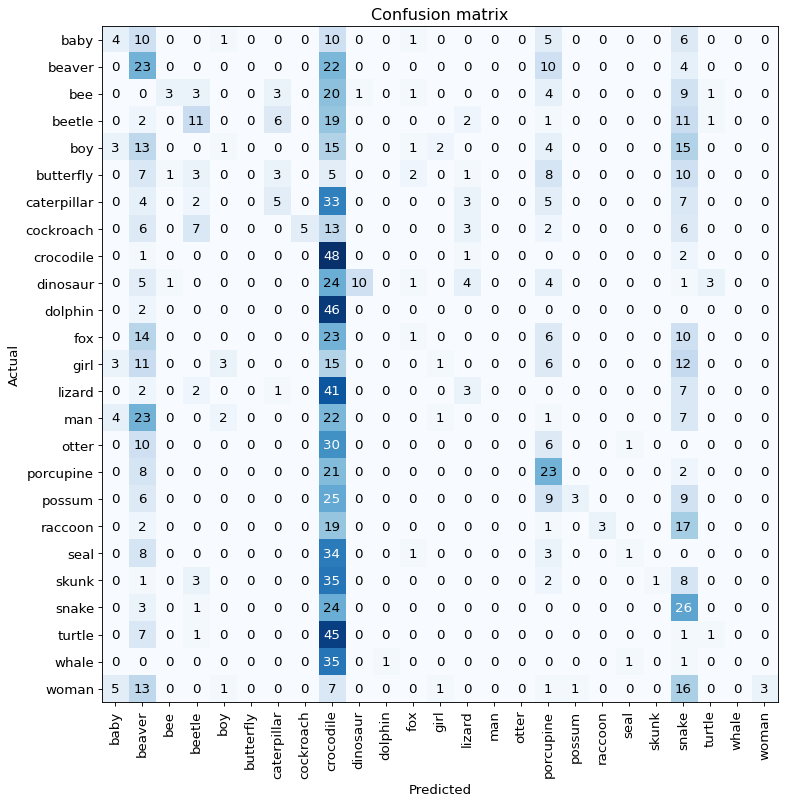

In [ ]:
train_preds, train_targets = learn.get_preds(ds_idx=0)
train_acc = accuracy(train_preds, train_targets)
print(f"Train Accuracy: {train_acc.item():.4f}")

val_loss, val_acc, val_f1 = learn.validate()
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10, 10), dpi=80)

test_dl = learn.dls.test_dl(files_test,with_labels=True)
test_loss, test_acc, test_f1 = learn.validate(dl=test_dl)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Los resultados en este caso han sido caóticos. El entrenamiento ha parado a las 13 épocas teniendo una paciencia de 10, lo que indica que el modelo no aprendía prácticamente nada.

Esto puede ser debido al exceso de dropout introducido, que ha impedido que el modelo aprenda aptrones significativos de los datos.

## Prueba 6

Vemos que el overfitting no lo podemos solucionar subiendo demasiado el dropout, así que lo que haremos será reducir el número de capas convolcuionales. Si tenemos un modelo demasiado complejo, éste aprenderá demasiado bien las características de los ejemplo y no será capaz de generalizar para nuevos ejemplos.

Eliminamos las dos últimas capas convolucionales, pero aumentaremos el tamaño los filtros convolucionales.

Ahora tenemos los siguientes parámetros entrenables:
- Primera capa convolucional:
<center>$(3 \cdot 5 \cdot 5 )\cdot 32 +32 = 2432$</center>

- Primera capa BN:
<center>$2 \cdot 32 = 64$</center>

- Segunda capa convolucional:
<center>$(32 \cdot 5 \cdot 5 )\cdot 64 + 64 = 51264$</center>

- Primera capa BN:
<center>$2 \cdot 64 = 128$</center>

- Primera capa densa:
<center>$(64 \cdot 10 \cdot 10 )\cdot 128 +128 = 819328$</center>

- Segunda capa densa:
<center>$128 \cdot 25 + 25 = 3225$</center>

Número total de parámetros = 876441.


In [ ]:
BaseNetMejorada = sequential(
    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=(5,5)), #imagenes 32x32 a 28x28
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.MaxPool2d(kernel_size=(2,2)), #imagenes 28x28 a 14x14
    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(5,5)), #imagenes 14x14 a 10x10
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Flatten(),
    nn.Linear(in_features=10*10*64,out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128,out_features=25)
  )

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,2.666327,2.497433,0.284800,0.252807,00:18
1,2.262491,2.203564,0.342400,0.319881,00:19
2,2.069506,2.279990,0.348000,0.346484,00:17
3,1.981449,2.334923,0.314400,0.321632,00:16
4,1.879178,2.353675,0.343200,0.348758,00:17
5,1.766565,2.164890,0.392000,0.380671,00:16
6,1.664866,1.817313,0.456800,0.451303,00:17
7,1.574314,2.209436,0.401600,0.422990,00:16
8,1.489529,1.834429,0.457600,0.455297,00:16
9,1.421830,1.564294,0.527200,0.517642,00:16


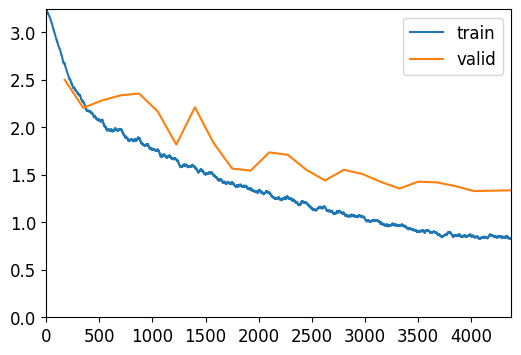

Sequential (Input shape: 64 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 32 x 28 x 28   
Conv2d                                    2432       True      
BatchNorm2d                               64         True      
ReLU                                                           
Dropout                                                        
____________________________________________________________________________
                     64 x 32 x 14 x 14   
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 64 x 10 x 10   
Conv2d                                    51264      True      
BatchNorm2d                               128        True      
ReLU                                                           
Dropout                                                        
_____________________________________

In [ ]:
learn = Learner(dls_aumentada, BaseNetMejorada, loss_func=CrossEntropyLossFlat(), metrics=[accuracy,F1Score(average='weighted')], cbs=[EarlyStoppingCallback(patience=10),ShowGraphCallback()])
#learn.lr_find()
#learn.recorder.plot_lr_find()
learn.fit_one_cycle(25)
learn.summary()

Train Accuracy: 0.7365


Validation Loss: 1.3351, Validation Accuracy: 0.5864


Test Loss: 1.2434, Test Accuracy: 0.6224


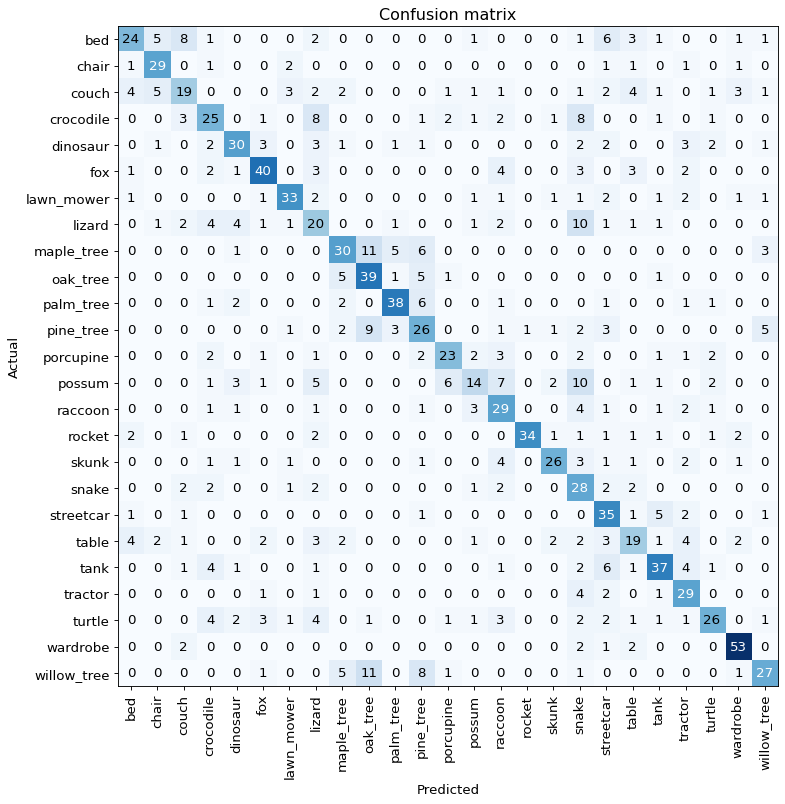

In [ ]:
train_preds, train_targets = learn.get_preds(ds_idx=0)
train_acc = accuracy(train_preds, train_targets)
print(f"Train Accuracy: {train_acc.item():.4f}")

val_loss, val_acc, val_f1 = learn.validate()
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10, 10), dpi=80)

test_dl = learn.dls.test_dl(files_test,with_labels=True)
test_loss, test_acc, test_f1 = learn.validate(dl=test_dl)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Los resultados son significativemnte mejores: llegamos a un validation accuracy de 0.58. Además, las curvas bajan más rápidamente y aunque hay overfitting, no es demasiado.

## Prueba 7

Veamos cómo funciona añadiendo en el modelo una nueva capa convolucional que permita aprender más sobre los datos.


Ahora tenemos los siguientes parámetros entrenables:
- Primera capa convolucional:
<center>$(3 \cdot 5 \cdot 5 )\cdot 32 +32 = 2432$</center>

- Primera capa BN:
<center>$2 \cdot 32 = 64$</center>

- Segunda capa convolucional:
<center>$(32 \cdot 5 \cdot 5 )\cdot 64 + 64 = 51264$</center>

- Segunda capa BN:
<center>$2 \cdot 64 = 128$</center>

- Tercera capa convolucional:
<center>$(64 \cdot 3 \cdot 3 )\cdot 128 + 128 = 73856$</center>

- Tercera capa BN:
<center>$2 \cdot 128 = 256$</center>

- Primera capa densa:
<center>$(128 \cdot 3 \cdot 3 )\cdot 128 +128 = 147584$</center>

- Segunda capa densa:
<center>$128 \cdot 25 + 25 = 3225$</center>

Número total de parámetros = 278809.

In [ ]:
BaseNetMejorada = sequential(
    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=(5,5)), #imagenes 32x32 a 28x28
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.MaxPool2d(kernel_size=(2,2)), #imagenes 28x28 a 14x14
    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(5,5)), #imagenes 14x14 a 10x10
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.MaxPool2d(kernel_size=(2,2)), #imagenes 10x10 a 5x5
    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(3,3)), #imagenes 5x5 a 3x3
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Flatten(),
    nn.Linear(in_features=3*3*128,out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128,out_features=25)
  )

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,2.950640,2.869238,0.213600,0.169670,00:17
1,2.434945,2.419208,0.304000,0.309655,00:16
2,2.114166,2.321041,0.320800,0.317580,00:16
3,1.919016,1.918929,0.410400,0.405287,00:16
4,1.832536,2.001256,0.384800,0.366365,00:16
5,1.754207,2.027558,0.392000,0.371543,00:16
6,1.649135,2.264790,0.333600,0.332088,00:16
7,1.582593,1.978207,0.424800,0.445985,00:16
8,1.490181,1.921741,0.444000,0.438474,00:16
9,1.412776,1.958377,0.425600,0.429106,00:16


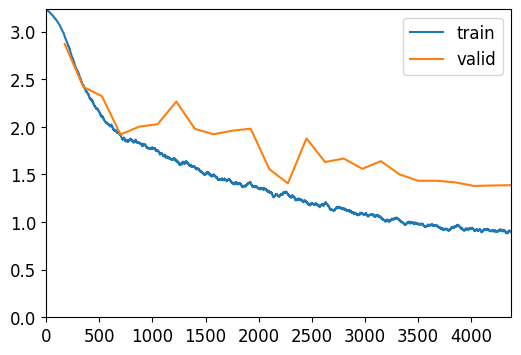

Sequential (Input shape: 64 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 32 x 28 x 28   
Conv2d                                    2432       True      
BatchNorm2d                               64         True      
ReLU                                                           
Dropout                                                        
____________________________________________________________________________
                     64 x 32 x 14 x 14   
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 64 x 10 x 10   
Conv2d                                    51264      True      
BatchNorm2d                               128        True      
ReLU                                                           
Dropout                                                        
_____________________________________

In [ ]:
learn = Learner(dls_aumentada, BaseNetMejorada, loss_func=CrossEntropyLossFlat(), metrics=[accuracy,F1Score(average='weighted')], cbs=[EarlyStoppingCallback(patience=10),ShowGraphCallback()])
#learn.lr_find()
#learn.recorder.plot_lr_find()
learn.fit_one_cycle(25, lr_max=slice(1e-4,1e-3))
learn.summary()

Train Accuracy: 0.6487


Validation Loss: 1.3867, Validation Accuracy: 0.5768


Test Loss: 1.3146, Test Accuracy: 0.5824


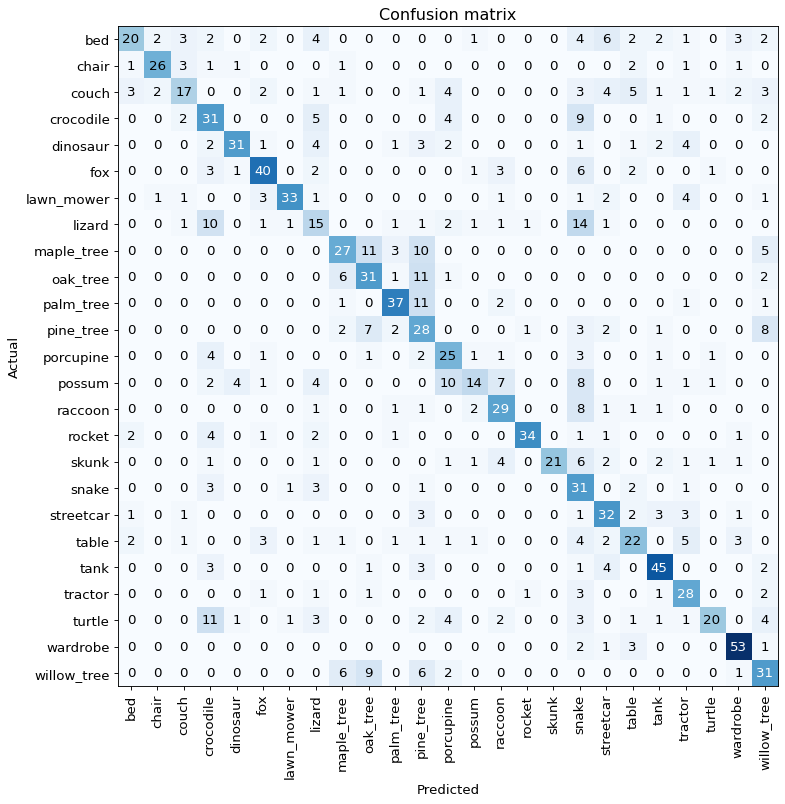

In [ ]:
train_preds, train_targets = learn.get_preds(ds_idx=0)
train_acc = accuracy(train_preds, train_targets)
print(f"Train Accuracy: {train_acc.item():.4f}")

val_loss, val_acc, val_f1 = learn.validate()
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10, 10), dpi=80)

test_dl = learn.dls.test_dl(files_test,with_labels=True)
test_loss, test_acc, test_f1 = learn.validate(dl=test_dl)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Hemos logrado una mayor precisión de entrenamiento y validación, lo que indica que la arquitectura ha mejorado. Podríamos añadir más épocas de entenamiento para aprovechar la nueva capa.

## Prueba 8

Ahora entrenaremos con 40 épocas, para que tenga más tiempo de entrenar.

El número de parámetros no ha cambiado, seguimos con la cantidad de 278809.

In [ ]:
BaseNetMejorada = sequential(
    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=(5,5)), #imagenes 32x32 a 28x28
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.MaxPool2d(kernel_size=(2,2)), #imagenes 28x28 a 14x14
    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(5,5)), #imagenes 14x14 a 10x10
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.MaxPool2d(kernel_size=(2,2)), #imagenes 10x10 a 5x5
    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(3,3)), #imagenes 5x5 a 3x3
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Flatten(),
    nn.Linear(in_features=3*3*128,out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128,out_features=25)
  )

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,2.939779,2.877315,0.220000,0.172882,00:16
1,2.626720,2.587245,0.294400,0.272938,00:14
2,2.360837,2.396589,0.306400,0.305306,00:15
3,2.128003,2.111249,0.384000,0.373387,00:16
4,1.988196,1.822778,0.454400,0.448554,00:15
5,1.892384,1.938268,0.438400,0.440180,00:15
6,1.864537,1.809921,0.451200,0.455190,00:15
7,1.778267,1.931080,0.428000,0.427398,00:15
8,1.718895,1.928617,0.440000,0.422486,00:15
9,1.669937,1.847440,0.452800,0.451842,00:15


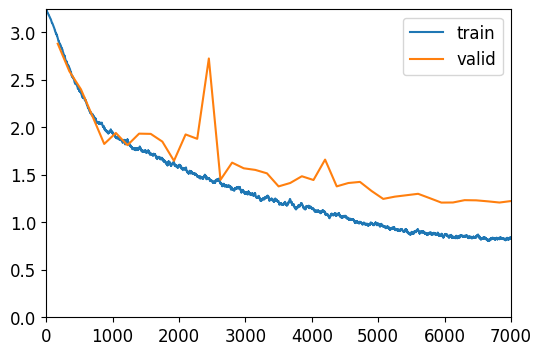

Sequential (Input shape: 64 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 32 x 28 x 28   
Conv2d                                    2432       True      
BatchNorm2d                               64         True      
ReLU                                                           
Dropout                                                        
____________________________________________________________________________
                     64 x 32 x 14 x 14   
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 64 x 10 x 10   
Conv2d                                    51264      True      
BatchNorm2d                               128        True      
ReLU                                                           
Dropout                                                        
_____________________________________

In [ ]:
learn = Learner(dls_aumentada, BaseNetMejorada, loss_func=CrossEntropyLossFlat(), metrics=[accuracy,F1Score(average='weighted')], cbs=[EarlyStoppingCallback(patience=10),ShowGraphCallback()])
#learn.lr_find()
#learn.recorder.plot_lr_find()
learn.fit_one_cycle(40)
learn.summary()

Train Accuracy: 0.7040


Validation Loss: 1.2224, Validation Accuracy: 0.6264


Test Loss: 1.2485, Test Accuracy: 0.6132


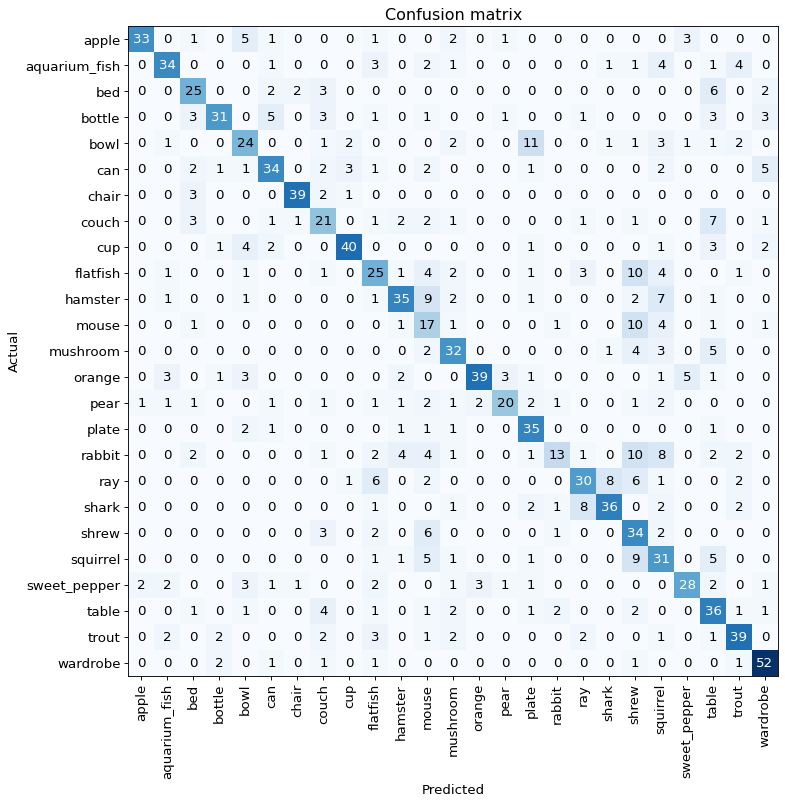

In [ ]:
train_preds, train_targets = learn.get_preds(ds_idx=0)
train_acc = accuracy(train_preds, train_targets)
print(f"Train Accuracy: {train_acc.item():.4f}")

val_loss, val_acc, val_f1 = learn.validate()
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10, 10), dpi=80)

test_dl = learn.dls.test_dl(files_test,with_labels=True)
test_loss, test_acc, test_f1 = learn.validate(dl=test_dl)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Vemos que los valores de las medidas de rendimeitno son bastante altas, casi llegando a 0.63 en validationa accuracy.

Este será el modelo con el que nos quedemos, ya que tras numerosos intentos después no hemos encontrado mejora. He intentado ajustar el learning rate _lr_find()_, buscando un intervalo que contubviese al valley y estuviese justo antes de que la curva incrementara, pero los resultados eran muy malos.

Intenté añadir padding para poder meter más capas convolcuionales, pero tampoco me sirvió.

He dejado unos pocos de los entrenamientos extra que hice: he incluido los que tenían mejores resultados, pero ninguno llegaba a 0.65 en validation accuracy.

## Prueba 13 -> No mejora

In [ ]:
BaseNetMejorada = sequential(
    nn.Conv2d(in_channels=3,out_channels=64,kernel_size=(5,5)), #imagenes 32x32 a 28x28
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2)), #imagenes 28x28 a 14x14
    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(5,5)), #imagenes 14x14 a 10x10
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2)), #imagenes 10x10 a 5x5
    nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(3,3)), #imagenes 5x5 a 3x3
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Conv2d(in_channels=256,out_channels=512,kernel_size=(3,3)), #imagenes 5x5 a 3x3
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=512,out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128,out_features=25)
  )

In [ ]:
learn = Learner(dls_aumentada, BaseNetMejorada, loss_func=CrossEntropyLossFlat(), metrics=[accuracy,F1Score(average='weighted')], cbs=[EarlyStoppingCallback(patience=10),ShowGraphCallback()])
#learn.lr_find()

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,2.975064,2.862189,0.181600,0.120177,00:17
1,2.647385,2.553227,0.241600,0.204038,00:17
2,2.425600,2.336020,0.277600,0.263068,00:17
3,2.268096,2.231062,0.314400,0.295850,00:17
4,2.187336,2.389698,0.293600,0.258674,00:17
5,2.144038,2.270605,0.298400,0.277020,00:18
6,2.091782,2.210026,0.316800,0.308273,00:17
7,2.044393,2.207228,0.320000,0.296567,00:17
8,1.995352,2.290529,0.328000,0.294091,00:18
9,1.925070,2.502984,0.264000,0.261349,00:18


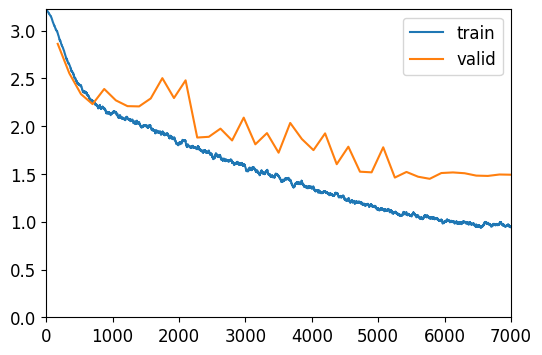

Sequential (Input shape: 64 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 28 x 28   
Conv2d                                    4864       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 14 x 14   
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 128 x 10 x 10  
Conv2d                                    204928     True      
BatchNorm2d                               256        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 128 x 5 x 5    
MaxPool2d                                     

In [ ]:
#learn.recorder.plot_lr_find()
learn.fit_one_cycle(40)
learn.summary()

Train Accuracy: 0.7576


Validation Loss: 1.4922, Validation Accuracy: 0.5504


Test Loss: 1.4671, Test Accuracy: 0.5640


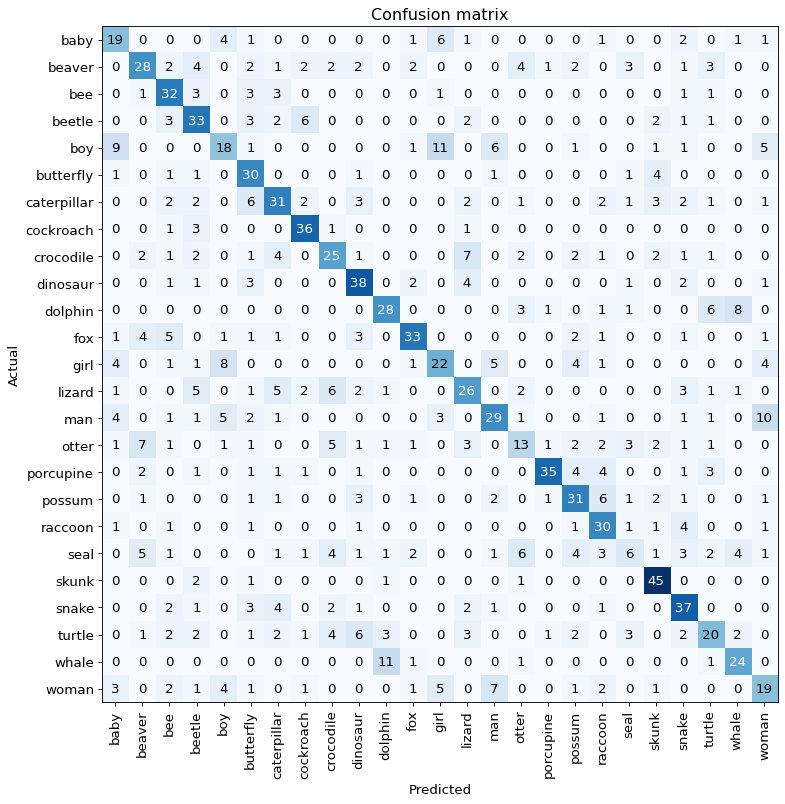

In [ ]:
train_preds, train_targets = learn.get_preds(ds_idx=0)
train_acc = accuracy(train_preds, train_targets)
print(f"Train Accuracy: {train_acc.item():.4f}")

val_loss, val_acc, val_f1 = learn.validate()
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10, 10), dpi=80)

test_dl = learn.dls.test_dl(files_test,with_labels=True)
test_loss, test_acc, test_f1 = learn.validate(dl=test_dl)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

## Prueba 14 -> No mejora

In [ ]:
BaseNetMejorada = sequential(
    nn.Conv2d(in_channels=3,out_channels=128,kernel_size=(3,3)), #imagenes 32x32 a 30x30
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.MaxPool2d(kernel_size=(2,2)), #imagenes 30x30 a 15x15
    nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(3,3)), #imagenes 15x15 a 13x13
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.MaxPool2d(kernel_size=(2,2)), #imagenes 13x13 a 6x6
    nn.Conv2d(in_channels=256,out_channels=512,kernel_size=(3,3)), #imagenes 6x6 a 4x4
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.MaxPool2d(kernel_size=(2,2)), #imagenes 4x4 a 2x2
    nn.Conv2d(in_channels=512,out_channels=512,kernel_size=(3,3),padding=1), #imagenes 2x2 a 2x2
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=512*2*2,out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128,out_features=25)
  )

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,2.650133,2.772260,0.213600,0.184306,00:17
1,2.378198,2.587045,0.249600,0.235777,00:17
2,2.209795,2.690163,0.200000,0.182116,00:18
3,2.121997,2.937236,0.147200,0.129514,00:18
4,2.062377,2.659016,0.213600,0.193892,00:18
5,2.019888,3.092051,0.156000,0.136610,00:20
6,1.994421,2.449652,0.238400,0.243455,00:17
7,1.934662,2.429938,0.268800,0.248100,00:18
8,1.851567,2.189764,0.348000,0.330974,00:19
9,1.800743,2.224991,0.287200,0.297450,00:17


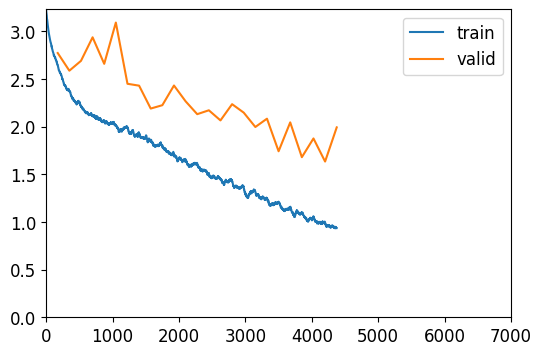

In [ ]:
learn = Learner(dls_aumentada, BaseNetMejorada, loss_func=CrossEntropyLossFlat(), metrics=[accuracy,F1Score(average='weighted')], cbs=[EarlyStoppingCallback(patience=10),ShowGraphCallback()])
#learn.lr_find()
#learn.recorder.plot_lr_find()
learn.fit_one_cycle(40)
learn.summary()

## Prueba 12 -> No mejora

In [ ]:
# creamos DataBlock
dls_aumentada = DataBlock(
    # imágenes como entrada y categorías como salida
    blocks=(ImageBlock, CategoryBlock),
    # obtenemos las imágenes
    get_items=get_image_files,
    # 10% del dataset para validación y 90% para train
    splitter=RandomSplitter(valid_pct=0.1, seed=42),
    # etiqueta extraida del nombre del directorio padre
    get_y=parent_label,
    # aplicamos transformaciones para data augmentation
    batch_tfms=aug_transforms(do_flip=True, # volteo horizontal aleatorio
                              flip_vert=False, # no activamos volteo vertical
                              max_rotate=10, # rotamos imágenes aleatoriamente máx 10 grados
                              max_zoom=1.2, # zoom aleatorio máx 20% mas grande
                              max_lighting=0.2, # brillo y contraste aleatorio
                              max_warp=0.2, # deformaciones pequeñas hasta 20%
                              p_affine=0.75, # probabilidad de aplicar transformaciones de afinidad
                              p_lighting=0.75) # probabilidad de aplicar transformaciones de iluminación
).dataloaders(path/'train', bs=64) # dataloader con batch size de 64

print('Numero de ejemplos de entrenamiento (una vez descartados los de validacion):', len(dls_aumentada.train_ds))
print('Numero de ejemplos de validacion:', len(dls_aumentada.valid_ds))

Numero de ejemplos de entrenamiento (una vez descartados los de validacion): 11250
Numero de ejemplos de validacion: 1250


In [ ]:
BaseNetMejorada = sequential(
    nn.Conv2d(in_channels=3,out_channels=64,kernel_size=(5,5)), #imagenes 32x32 a 28x28
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2)), #imagenes 28x28 a 14x14
    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(5,5)), #imagenes 14x14 a 10x10
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2)), #imagenes 10x10 a 5x5
    nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(3,3)), #imagenes 5x5 a 3x3
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Conv2d(in_channels=256,out_channels=512,kernel_size=(3,3)), #imagenes 5x5 a 3x3
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=512,out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128,out_features=25)
  )

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(valley=0.002511886414140463)

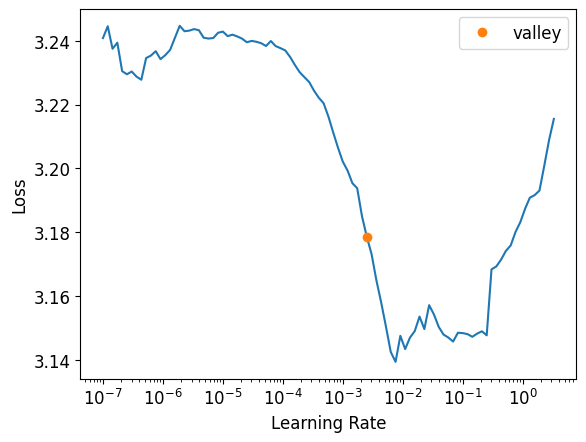

In [ ]:
learn = Learner(dls_aumentada, BaseNetMejorada, loss_func=CrossEntropyLossFlat(), metrics=[accuracy,F1Score(average='weighted')], cbs=[EarlyStoppingCallback(patience=10),ShowGraphCallback()])
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,2.658350,2.580482,0.211200,0.183498,00:17
1,2.468855,2.426579,0.254400,0.218598,00:17
2,2.323658,2.237656,0.299200,0.275558,00:16
3,2.224538,3.345114,0.184000,0.152431,00:18
4,2.147744,2.590993,0.268000,0.239859,00:17
5,2.070025,2.063051,0.362400,0.332102,00:17
6,2.019798,2.040784,0.364000,0.342669,00:17
7,1.961370,2.212450,0.346400,0.330662,00:17
8,1.921032,2.010164,0.388000,0.372485,00:17
9,1.875375,1.923235,0.409600,0.392485,00:17


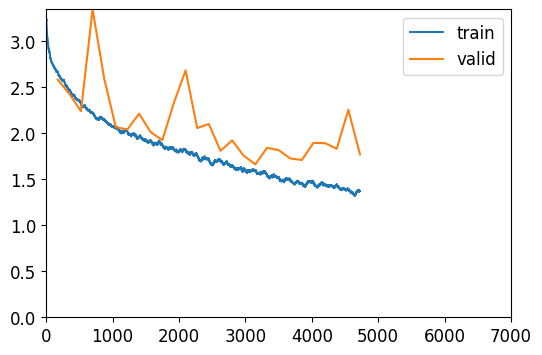

No improvement since epoch 17: early stopping


Sequential (Input shape: 64 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 28 x 28   
Conv2d                                    4864       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 14 x 14   
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 128 x 10 x 10  
Conv2d                                    204928     True      
BatchNorm2d                               256        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 128 x 5 x 5    
MaxPool2d                                     

In [ ]:
#learn.recorder.plot_lr_find()
learn.fit(40, lr=0.002511)
learn.summary()

Train Accuracy: 0.6283


Validation Loss: 1.7080, Validation Accuracy: 0.4896


Test Loss: 1.7463, Test Accuracy: 0.4848


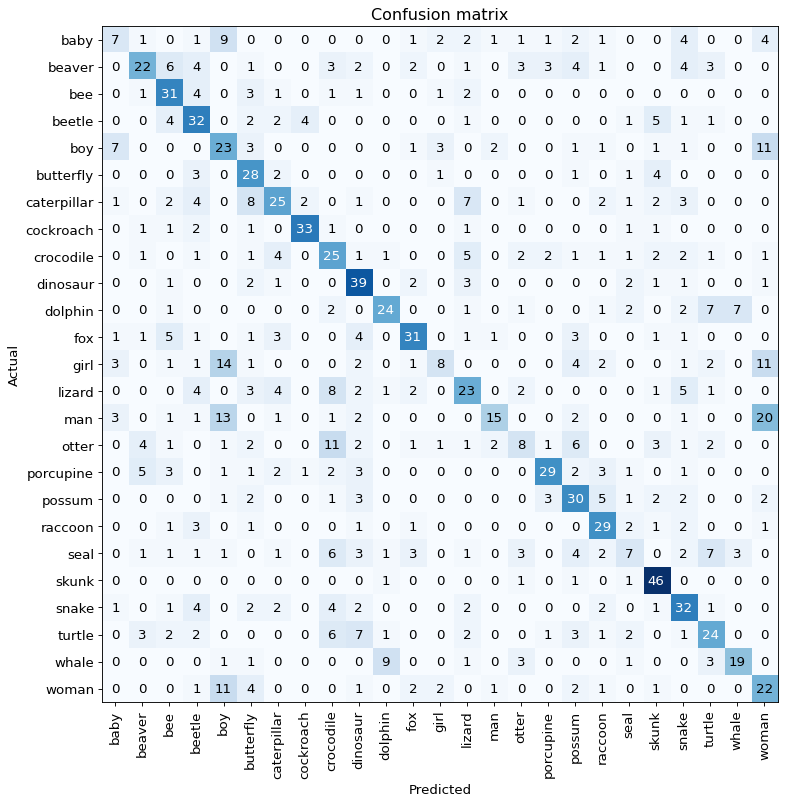

In [ ]:
train_preds, train_targets = learn.get_preds(ds_idx=0)
train_acc = accuracy(train_preds, train_targets)
print(f"Train Accuracy: {train_acc.item():.4f}")

val_loss, val_acc, val_f1 = learn.validate()
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10, 10), dpi=80)

test_dl = learn.dls.test_dl(files_test,with_labels=True)
test_loss, test_acc, test_f1 = learn.validate(dl=test_dl)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

## Prueba 9 -> No mejora

In [ ]:
BaseNetMejorada = sequential(
    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=(5,5),padding=2,norm_type=NormType.Batch), #imágenes 32x32 a 32x32
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.MaxPool2d(kernel_size=(2,2)), #imagenes 32x32 a 16x16
    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(5,5),padding=2), #imágenes 16x16 a 16x16
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Flatten(),
    nn.Linear(in_features=16*16*64,out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128,out_features=25)
  )

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,2.532574,2.365351,0.320800,0.304449,00:17
1,2.172043,2.074392,0.397600,0.376114,00:16
2,2.036561,2.008765,0.411200,0.398775,00:16
3,1.924217,2.087420,0.387200,0.370500,00:16
4,1.859202,2.135424,0.394400,0.374068,00:15
5,1.721367,1.993575,0.416000,0.407418,00:15
6,1.665553,1.778894,0.488000,0.474381,00:15
7,1.592976,1.808448,0.459200,0.460334,00:15
8,1.485629,2.216147,0.371200,0.379620,00:15
9,1.407438,1.845079,0.450400,0.445131,00:15


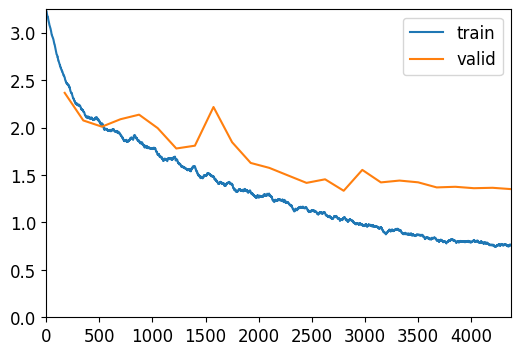

Sequential (Input shape: 64 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 32 x 32 x 32   
Conv2d                                    2432       True      
BatchNorm2d                               64         True      
ReLU                                                           
Dropout                                                        
____________________________________________________________________________
                     64 x 32 x 16 x 16   
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 64 x 16 x 16   
Conv2d                                    51264      True      
BatchNorm2d                               128        True      
ReLU                                                           
Dropout                                                        
_____________________________________

In [ ]:
learn = Learner(dls_aumentada, BaseNetMejorada, loss_func=CrossEntropyLossFlat(), metrics=[accuracy,F1Score(average='weighted')], cbs=[EarlyStoppingCallback(patience=10),ShowGraphCallback()])
#learn.lr_find()
#learn.recorder.plot_lr_find()
learn.fit_one_cycle(25)
learn.summary()

## Prueba 10 -> No mejora

In [ ]:
BaseNetMejorada = sequential(
    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=(5,5),padding=2), #imágenes 32x32 a 32x32
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.MaxPool2d(kernel_size=(2,2)), #imagenes 32x32 a 16x16
    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(5,5),padding=2), #imágenes 16x16 a 16x16
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Flatten(),
    nn.Linear(in_features=16*16*64,out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512,out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128,out_features=25)
  )

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,2.509420,2.349383,0.309600,0.287045,00:16
1,2.194849,2.075514,0.388000,0.381153,00:16
2,2.004540,2.038299,0.411200,0.396947,00:16
3,1.902395,2.366056,0.335200,0.349397,00:18
4,1.812040,2.266977,0.381600,0.369146,00:18
5,1.754731,2.673318,0.317600,0.316238,00:16
6,1.628234,1.966906,0.415200,0.417095,00:16
7,1.527466,1.914024,0.451200,0.461424,00:16
8,1.446560,1.764186,0.490400,0.480005,00:16
9,1.354951,1.626806,0.519200,0.512673,00:16


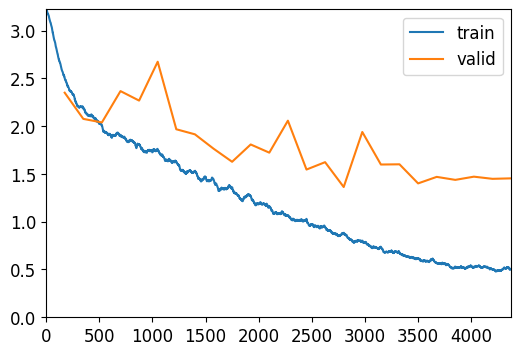

Sequential (Input shape: 64 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 32 x 32 x 32   
Conv2d                                    2432       True      
BatchNorm2d                               64         True      
ReLU                                                           
Dropout                                                        
____________________________________________________________________________
                     64 x 32 x 16 x 16   
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 64 x 16 x 16   
Conv2d                                    51264      True      
BatchNorm2d                               128        True      
ReLU                                                           
Dropout                                                        
_____________________________________

In [ ]:
learn = Learner(dls_aumentada, BaseNetMejorada, loss_func=CrossEntropyLossFlat(), metrics=[accuracy,F1Score(average='weighted')], cbs=[EarlyStoppingCallback(patience=10),ShowGraphCallback()])
#learn.lr_find()
#learn.recorder.plot_lr_find()
learn.fit_one_cycle(25)
learn.summary()

## Prueba 11: ejecutando 2 veces el learner -> No mejora

In [ ]:
BaseNetMejorada = sequential(
    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=(5,5),padding=2), #imágenes 32x32 a 32x32
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.MaxPool2d(kernel_size=(2,2)), #imagenes 32x32 a 16x16
    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(5,5),padding=2), #imágenes 16x16 a 16x16
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.MaxPool2d(kernel_size=(2,2)), #imagenes 16x16 a 8x8
    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(5,5),padding=2), #imagenes 8x8 a 8x8
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=8*8*128,out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512,out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128,out_features=25)
  )

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.397557,1.638330,0.584000,0.588549,00:19
1,0.425865,1.697029,0.587200,0.591890,00:16
2,0.514278,1.721796,0.576800,0.579755,00:19
3,0.610626,2.580087,0.439200,0.449312,00:23
4,0.692514,2.635371,0.434400,0.451243,00:19
5,0.706035,1.651849,0.560800,0.567307,00:19
6,0.730870,2.114104,0.496000,0.517595,00:19
7,0.722935,2.454909,0.444000,0.454391,00:18
8,0.651653,2.283689,0.492000,0.507900,00:21
9,0.614141,2.386337,0.490400,0.507907,00:17


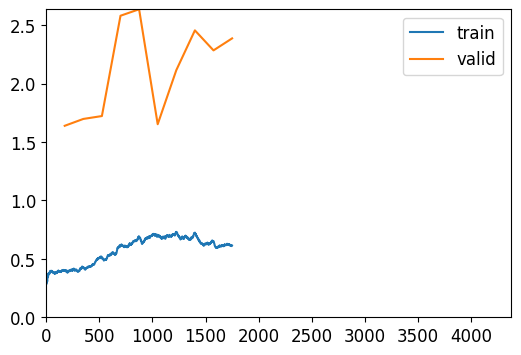

No improvement since epoch 0: early stopping


Sequential (Input shape: 64 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 32 x 32 x 32   
Conv2d                                    2432       True      
BatchNorm2d                               64         True      
ReLU                                                           
Dropout                                                        
____________________________________________________________________________
                     64 x 32 x 16 x 16   
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 64 x 16 x 16   
Conv2d                                    51264      True      
BatchNorm2d                               128        True      
ReLU                                                           
Dropout                                                        
_____________________________________

In [ ]:
learn = Learner(dls_aumentada, BaseNetMejorada, loss_func=CrossEntropyLossFlat(), metrics=[accuracy,F1Score(average='weighted')], cbs=[EarlyStoppingCallback(patience=10),ShowGraphCallback()])
#learn.lr_find()
#learn.recorder.plot_lr_find()
learn.fit_one_cycle(25)
learn.summary()